# Project - Predicting Customer Churn for Bank Customers with Machine Learning

## Introduction
Di tengah lanskap industri perbankan yang sangat kompetitif, akuisisi pelanggan baru seringkali memakan biaya yang jauh lebih besar daripada mempertahankan pelanggan yang sudah ada. Berbagai studi, termasuk dari Harvard Business Review, menunjukkan bahwa biaya untuk mendapatkan pelanggan baru bisa 5 hingga 25 kali lebih mahal daripada mempertahankan pelanggan lama. Oleh karena itu, customer churn—fenomena di mana pelanggan berhenti menggunakan layanan suatu bank—menjadi salah satu tantangan paling krusial yang dihadapi institusi perbankan saat ini.

Kehilangan pelanggan tidak hanya berarti kehilangan pendapatan di masa kini, tetapi juga hilangnya potensi keuntungan di masa depan melalui produk-produk lain (cross-selling). Lebih dari itu, pelanggan yang tidak puas dapat memberikan ulasan negatif yang merusak reputasi dan menghalangi calon pelanggan baru.

Pendekatan reaktif, yaitu menunggu pelanggan pergi baru kemudian menganalisis penyebabnya, sudah tidak lagi cukup. Diperlukan strategi proaktif untuk mengidentifikasi pelanggan yang berisiko churn sebelum mereka benar-benar mengambil keputusan. Di sinilah kekuatan analisis data dan machine learning berperan. Dengan memanfaatkan data historis yang dimiliki bank—seperti demografi nasabah, saldo, jumlah produk yang dimiliki, dan aktivitas transaksi—kita dapat membangun sebuah model prediksi yang cerdas.

Proyek ini bertujuan untuk membangun dan mengevaluasi beberapa model klasifikasi machine learning untuk memprediksi kemungkinan seorang nasabah bank akan melakukan churn. Hasil dari model ini dapat menjadi dasar bagi tim retensi untuk merancang kampanye yang tepat sasaran, seperti memberikan penawaran khusus atau layanan personal kepada pelanggan yang teridentifikasi berisiko tinggi, sehingga pada akhirnya dapat meningkatkan loyalitas dan profitabilitas bank.

## Objective
Berdasarkan permasalahan yang telah diuraikan pada bagian Pendahuluan, proyek ini memiliki beberapa tujuan utama yang ingin dicapai, yaitu:

1. Analisis Data Eksplorasi (EDA): Melakukan analisis mendalam terhadap data untuk menemukan pola dan wawasan. Ini termasuk memahami karakteristik demografis dan perilaku perbankan dari pelanggan yang cenderung churn dibandingkan dengan pelanggan yang loyal.

2. Identifikasi Faktor Pendorong Churn: Mengidentifikasi variabel-variabel atau fitur-fitur kunci (misalnya, saldo, usia, jumlah produk, tingkat aktivitas) yang paling signifikan dalam mempengaruhi keputusan seorang pelanggan untuk meninggalkan bank.

3. Pembangunan Model Prediktif: Membangun, melatih, dan membandingkan beberapa model klasifikasi machine learning yang mampu memprediksi pelanggan mana yang berisiko tinggi untuk churn.

4. Evaluasi Performa Model: Mengevaluasi setiap model menggunakan metrik yang relevan untuk kasus bisnis ini. Selain Akurasi, evaluasi akan menekankan pada Presisi, Recall, dan F1-Score untuk memastikan model dapat secara efektif mengidentifikasi kelas minoritas (pelanggan yang churn), yang merupakan target utama kita.

5. Penentuan Model Terbaik: Menentukan model final yang paling optimal dan dapat diandalkan untuk diimplementasikan oleh bank, berdasarkan hasil perbandingan performa yang komprehensif.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

# Data Viz Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict, learning_curve
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, precision_recall_curve, auc

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Statistical Libraries
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE

# Supress Warnings
import warnings
warnings.filterwarnings("ignore")

## Set Function and Variables

In [2]:
# Mendefinisikan ukuran font dasar
base_font_size = 20

# Menyesuaikan ukuran font untuk berbagai elemen plot
plt.rcParams.update({
    'axes.labelsize': base_font_size,
    'axes.titlesize': base_font_size + 2,
    'xtick.labelsize': base_font_size - 2,
    'ytick.labelsize': base_font_size - 2,
    'legend.fontsize': base_font_size - 2
})

# Palet warna yang berbeda
main_colors = ['#00A5E0', '#DD403A']
category_colors = [
    '#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9',
    '#845EC2', '#8f9aaa', '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3'
]
comparison_colors = [
    '#4682B4', '#2E8B57', '#000000', '#FF8C00', '#800080',
    '#B22222', '#708090'
] # Mengganti 'steelblue' menjadi '#4682B4', dsb.

# Variabel konfigurasi
seed_value = 42
evaluation_metric = 'recall'

# Kamus untuk menyimpan hasil perbandingan (inisialisasi kosong)
model_comparison_results = {}
test_comparison_results = {}

print('✅ Parameter dan Variabel Default Telah Ditetapkan!')

✅ Parameter dan Variabel Default Telah Ditetapkan!


In [3]:
def analyze_feature_distribution(column_name):
    '''
    Membuat histogram dan boxplot untuk membandingkan distribusi
    fitur numerik antara pelanggan yang churn dan yang tidak churn.
    '''
    # Buat salinan DataFrame untuk menghindari modifikasi data asli
    processed_df = train_df.copy()
    processed_df['Exited'] = processed_df['Exited'].astype('category')

    # Siapkan figure dan axes untuk plot histogram dan boxplot
    figure, (histogram_ax, boxplot_ax) = plt.subplots(
        nrows=2,
        figsize=(9, 7),
        sharex=True, # Memastikan sumbu x berbagi skala yang sama
        gridspec_kw={'height_ratios': (0.7, 0.3)} # Mengatur rasio tinggi subplots
    )

    # Memisahkan data berdasarkan status churn
    # Iterasi untuk membuat histogram untuk kedua kelompok
    for data_subset, plot_color, plot_label in zip([df_retained, df_churned], main_colors, ['Pelanggan Bertahan', 'Pelanggan Churn']):
        sns.histplot(
            data=data_subset,
            x=column_name,
            bins=15,
            color=plot_color,
            alpha=0.66,
            edgecolor='darkred', # Mengubah warna tepi
            label=plot_label,
            kde=False,
            ax=histogram_ax
        )
    histogram_ax.legend(title='Status Pelanggan') # Menambahkan judul legend

    # Membuat boxplot untuk visualisasi distribusi yang lebih detail
    sns.boxplot(
        x=column_name,
        y='Exited',
        data=processed_df,
        palette=main_colors,
        ax=boxplot_ax
    )
    boxplot_ax.set_ylabel('Status Churn') # Mengubah label sumbu y
    boxplot_ax.set_yticklabels(['Bertahan', 'Churn']) # Mengubah label tick sumbu y

    plt.tight_layout() # Mengatur layout agar tidak tumpang tindih


print('✔️ Fungsi Visualisasi Distribusi Fitur Dibuat!')

✔️ Fungsi Visualisasi Distribusi Fitur Dibuat!


In [4]:
def visualize_categorical_impact(categorical_column):
    '''
    Untuk fitur kategorikal, buat plot countplot yang menampilkan jumlah total
    setiap kategori dan barplot yang menunjukkan tingkat churn untuk setiap kategori.
    '''
    # Buat figure dan axes untuk dua subplot berdampingan
    chart_figure, (count_ax, churn_rate_ax) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot countplot untuk menampilkan distribusi kategori berdasarkan status churn
    sns.countplot(
        x=categorical_column,
        hue='Exited',
        data=train_df,
        palette=main_colors,
        ax=count_ax
    )
    count_ax.set_ylabel('Total Count') 
    count_ax.legend(labels=['Pelanggan Tetap', 'Pelanggan Churn']) 

    # Plot barplot untuk menampilkan tingkat churn per kategori
    sns.barplot(
        x=categorical_column,
        y='Exited', 
        data=train_df,
        palette=category_colors, 
        ax=churn_rate_ax
    )
    churn_rate_ax.set_ylabel('Tingkat Churn') 

    # Menyesuaikan label tick sumbu X jika fitur adalah 'HasCrCard' atau 'IsActiveMember'
    if categorical_column in ['HasCrCard', 'IsActiveMember']:
        # Mengubah label tick menjadi 'Tidak' dan 'Ya'
        count_ax.set_xticklabels(['Tidak', 'Ya'])
        churn_rate_ax.set_xticklabels(['Tidak', 'Ya'])

    plt.tight_layout() 


print('✔️ Fungsi Plot Kategorikal Tersedia!')

✔️ Fungsi Plot Kategorikal Tersedia!


In [5]:
def display_confusion_matrix(matrix_data, target_axes):
    '''
    Memplot confusion matrix pada objek axes yang ditentukan.
    '''
    # Membuat heatmap untuk visualisasi confusion matrix
    sns.heatmap(
        data=matrix_data,
        annot=True,         # Menampilkan nilai numerik di sel
        cmap='Blues',       # Menggunakan colormap 'Blues'
        annot_kws={'fontsize': 30}, # Mengatur ukuran font anotasi
        ax=target_axes      # Menentukan axes mana yang akan digunakan
    )

    # Mengatur label sumbu X (Label Prediksi)
    target_axes.set_xlabel('Label Prediksi')
    target_axes.set_xticks([0.5, 1.5]) # Mengatur posisi tick sumbu X
    target_axes.set_xticklabels(['Bertahan', 'Churn']) # Mengatur label tick sumbu X

    # Mengatur label sumbu Y (Label Sebenarnya)
    target_axes.set_ylabel('Label Sebenarnya')
    target_axes.set_yticks([0.25, 1.25]) # Mengatur posisi tick sumbu Y
    target_axes.set_yticklabels(['Bertahan', 'Churn']) # Mengatur label tick sumbu Y


print('✔️ Fungsi Plot Confusion Matrix Telah Dibuat!')

✔️ Fungsi Plot Confusion Matrix Telah Dibuat!


In [6]:
def visualize_model_learning(
    model_estimator,
    features_data,
    target_data,
    plot_axes,
    cross_validation_strategy=None,
    sample_sizes=np.linspace(0.1, 1.0, 5)
):
    '''
    Membuat plot kurva pembelajaran untuk sebuah estimator pada objek axes yang diberikan.
    Plot ini menunjukkan bagaimana skor pelatihan dan validasi berubah seiring peningkatan
    jumlah sampel pelatihan.
    '''
    # Menghitung skor pelatihan dan pengujian menggunakan fungsi learning_curve
    train_sizes_output, training_scores, validation_scores = learning_curve(
        estimator=model_estimator,
        X=features_data,
        y=target_data,
        cv=cross_validation_strategy,
        n_jobs=-1,  # Menggunakan semua core CPU yang tersedia
        train_sizes=sample_sizes,
        scoring='accuracy' # Menggunakan akurasi sebagai metrik penilaian
    )

    # Menghitung rata-rata dan standar deviasi dari skor pelatihan dan validasi
    mean_train_scores = np.mean(training_scores, axis=1)
    std_train_scores = np.std(training_scores, axis=1)
    mean_validation_scores = np.mean(validation_scores, axis=1)
    std_validation_scores = np.std(validation_scores, axis=1)

    # Mengisi area di sekitar kurva untuk menunjukkan variasi (standar deviasi)
    plot_axes.fill_between(
        train_sizes_output,
        mean_train_scores - std_train_scores,
        mean_train_scores + std_train_scores,
        alpha=0.1,
        color='mediumblue', # Mengubah warna
        label='Deviasi Standar Pelatihan' # Menambahkan label untuk area
    )
    plot_axes.fill_between(
        train_sizes_output,
        mean_validation_scores - std_validation_scores,
        mean_validation_scores + std_validation_scores,
        alpha=0.1,
        color='darkorange', # Mengubah warna
        label='Deviasi Standar Validasi Silang' # Menambahkan label untuk area
    )

    # Memplot garis rata-rata skor pelatihan
    plot_axes.plot(
        train_sizes_output,
        mean_train_scores,
        color='royalblue', # Mengubah warna
        marker='o',
        linestyle='-',
        label='Skor Pelatihan'
    )
    # Memplot garis rata-rata skor validasi silang
    plot_axes.plot(
        train_sizes_output,
        mean_validation_scores,
        color='orangered', # Mengubah warna
        marker='o',
        linestyle='-',
        label='Skor Validasi Silang'
    )

    # Mengatur label sumbu dan legenda
    plot_axes.set_xlabel('Jumlah Contoh Pelatihan')
    plot_axes.set_ylabel('Skor')
    plot_axes.legend(loc='best', fontsize=12) # Mengubah ukuran font legenda
    # plot_axes.grid(True) # Opsional: menambahkan grid untuk keterbacaan

print('✔️ Fungsi Kurva Pembelajaran Siap Digunakan!')

✔️ Fungsi Kurva Pembelajaran Siap Digunakan!


In [7]:
def evaluate_classifier_performance(
    trained_classifier,
    model_full_name,
    model_short_name
):
    '''
    Menampilkan performa keseluruhan dari sebuah model klasifikasi dengan
    menyajikan skor terbaik, parameter optimal, confusion matrix, dan kurva pembelajaran.
    '''
    print(f'\n--- {model_full_name} ---') # Menggunakan f-string untuk print lebih modern
    print('-------------------------------')
    # Asumsi 'scoring_metric' didefinisikan secara global atau dilewatkan sebagai parameter
    print(f'   Skor Terbaik ({evaluation_metric}): {np.round(trained_classifier.best_score_, 3)}')
    print('   Parameter Terbaik:')
    for param_key, param_value in trained_classifier.best_params_.items():
        print(f'     - {param_key}: {param_value}')

    # Melakukan prediksi probabilitas dan kelas pada data pelatihan menggunakan cross-validation
    # Asumsi X_train dan y_train sudah didefinisikan
    predicted_probabilities = cross_val_predict(
        estimator=trained_classifier.best_estimator_,
        X=X_train,
        y=y_train,
        cv=5, # Menggunakan 5-fold cross-validation
        method='predict_proba'
    )[:, 1]
    predicted_classes = predicted_probabilities.round()

    # Menghitung confusion matrix
    conf_matrix = confusion_matrix(y_train, predicted_classes, normalize='true')

    # Menghitung False Positive Rate (FPR) dan True Positive Rate (TPR) untuk kurva ROC
    false_pos_rate, true_pos_rate, _ = roc_curve(y_train, predicted_probabilities)

    # Menyimpan metrik performa ke dalam kamus perbandingan
    # Asumsi 'comparison_dict' sudah didefinisikan secara global
    model_comparison_results[model_short_name] = [
        accuracy_score(y_train, predicted_classes),
        precision_score(y_train, predicted_classes),
        recall_score(y_train, predicted_classes),
        roc_auc_score(y_train, predicted_probabilities),
        false_pos_rate,
        true_pos_rate
    ]

    # Membuat figure dengan dua subplot
    fig_performance, (ax_conf_matrix, ax_learning_curve) = plt.subplots(1, 2, figsize=(12, 5))

    # Memanggil fungsi plot_conf_mx (atau display_confusion_matrix) untuk confusion matrix
    # Menggunakan nama fungsi yang sudah diparafrase sebelumnya
    display_confusion_matrix(conf_matrix, ax_conf_matrix)

    # Memanggil fungsi plot_learning_curve (atau visualize_model_learning) untuk kurva pembelajaran
    # Menggunakan nama fungsi yang sudah diparafrase sebelumnya
    visualize_model_learning(trained_classifier.best_estimator_, X_train, y_train, ax_learning_curve)

    plt.tight_layout() # Menyesuaikan layout agar tidak tumpang tindih


print('✔️ Fungsi Evaluasi Performa Klasifikasi Siap!')

✔️ Fungsi Evaluasi Performa Klasifikasi Siap!


In [8]:
def display_feature_importance(model_estimator, model_name, plot_color, target_axes):
    '''
    Membuat plot barplot yang menampilkan tingkat kepentingan fitur (feature importance)
    untuk sebuah model klasifikasi pada objek axes yang ditentukan.
    '''
    # Mengambil nilai kepentingan fitur dari estimator terbaik model
    # Asumsi X_train sudah didefinisikan (digunakan untuk nama kolom)
    feature_importances_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': np.round(model_estimator.best_estimator_.feature_importances_, 3)
    })

    # Mengurutkan fitur berdasarkan kepentingannya secara menaik dan mengatur 'Feature' sebagai indeks
    sorted_importances = feature_importances_df.sort_values(
        by='Importance',
        ascending=True
    ).set_index('Feature')

    # Membuat barplot horizontal menggunakan fungsi plot bawaan pandas
    sorted_importances.plot.barh(
        color=plot_color,
        edgecolor='darkred', # Mengubah warna tepi bar
        legend=False, # Tidak menampilkan legenda karena hanya ada satu seri
        ax=target_axes
    )

    # Mengatur judul plot dan label sumbu
    target_axes.set_title(model_name)
    target_axes.set_xlabel('Tingkat Kepentingan') # Mengubah label sumbu X


print('✔️ Fungsi Visualisasi Pentingnya Fitur Dibuat!')

✔️ Fungsi Visualisasi Pentingnya Fitur Dibuat!


In [9]:
def evaluate_model_on_test_set(
    trained_model,
    model_identifier,
    target_axes
):
    '''
    Menilai performa model klasifikasi pada set data uji (test set)
    dan memplot confusion matrix yang dihasilkan.
    '''
    # Lakukan prediksi pada data uji
    # Asumsi X_test dan y_test sudah didefinisikan
    test_predictions = trained_model.predict(X_test)

    # Hitung confusion matrix, dinormalisasi berdasarkan label sebenarnya
    test_confusion_matrix = confusion_matrix(y_test, test_predictions, normalize='true')

    # Simpan metrik performa ke dalam kamus perbandingan test (test comparison dictionary)
    # Asumsi 'comparison_test_dict' sudah didefinisikan secara global
    test_comparison_results[model_identifier] = [
        accuracy_score(y_test, test_predictions),
        precision_score(y_test, test_predictions),
        recall_score(y_test, test_predictions)
    ]

    # Visualisasikan confusion matrix menggunakan heatmap
    sns.heatmap(
        test_confusion_matrix,
        annot=True,              # Tampilkan nilai di setiap sel
        annot_kws={'fontsize': 24}, # Atur ukuran font anotasi
        cmap='Blues',            # Gunakan colormap 'Blues'
        ax=target_axes           # Plot pada axes yang diberikan
    )

    # Atur judul plot
    target_axes.set_title(model_identifier)

    # Atur label dan tick untuk sumbu X (Label Prediksi)
    target_axes.set_xlabel('Label Prediksi')
    target_axes.set_xticks([0.5, 1.5])
    target_axes.set_xticklabels(['Bertahan', 'Churn']) # Mengubah label ke Bahasa Indonesia

    # Atur label dan tick untuk sumbu Y (Label Sebenarnya)
    target_axes.set_ylabel('Label Sebenarnya')
    target_axes.set_yticks([0.2, 1.4])
    target_axes.set_yticklabels(['Bertahan', 'Churn']) # Mengubah label ke Bahasa Indonesia


print('✔️ Fungsi Evaluasi Test Set Siap Digunakan!')

✔️ Fungsi Evaluasi Test Set Siap Digunakan!


## Data Overview

In [10]:
# --- 1. Memuat Data (Loading Data) ---
# Memuat dataset Churn_Modelling.csv
# Pastikan file 'Churn_Modelling.csv' berada di direktori yang sama dengan notebook ini,
# atau sediakan path lengkap ke file tersebut.
try:
    df = pd.read_csv('Churn_Modelling.csv')
    print("Dataset berhasil dimuat!")
    print(df.head())
except FileNotFoundError:
    print("Error: File 'Churn_Modelling.csv' tidak ditemukan. Pastikan file berada di direktori yang benar.")
    # Exit atau tangani error lebih lanjut jika file tidak ada
    exit()

# Menampilkan informasi dasar dataset
print("\n--- Informasi Dataset ---")
df.info()

# Menampilkan statistik deskriptif
print("\n--- Statistik Deskriptif ---")
print(df.describe().T)

Dataset berhasil dimuat!
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.6

In [11]:
# --- 2. Pembersihan dan Persiapan Data Awal (Initial Data Cleaning and Preparation) ---

# Menghapus kolom yang tidak relevan untuk prediksi churn
# 'RowNumber', 'CustomerId', 'Surname' biasanya tidak memberikan informasi prediktif
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
print("\nKolom 'RowNumber', 'CustomerId', 'Surname' berhasil dihapus.")

# Mengidentifikasi missing values
print("\n--- Melakukan pengecekan terhadap missing values ---")
print(df.isnull().sum())
# Untuk dataset ini, sepertinya tidak ada missing values, tapi langkah ini penting


Kolom 'RowNumber', 'CustomerId', 'Surname' berhasil dihapus.

--- Melakukan pengecekan terhadap missing values ---
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64



--- Distribusi Variabel Target (Exited) ---
Exited
0    6370
1    1630
Name: count, dtype: int64
Exited
0    79.625
1    20.375
Name: proportion, dtype: float64


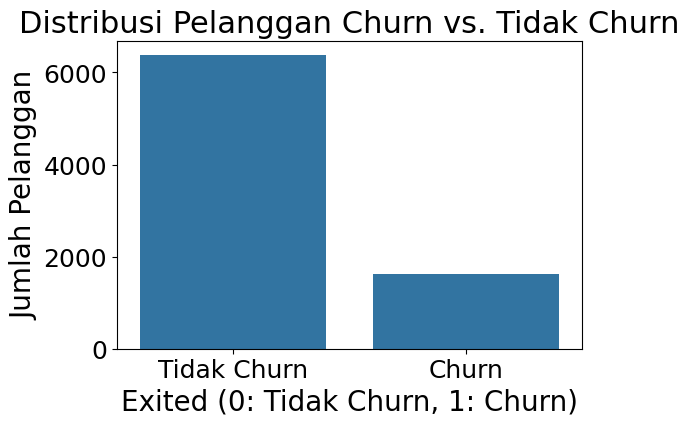

In [12]:
# --- 3. Pembagian data latih dan data uji (Train-Test Split) ---
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Exited'])

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Analisis distribusi variabel target (Exited)
print("\n--- Distribusi Variabel Target (Exited) ---")
print(train_df['Exited'].value_counts())
print(train_df['Exited'].value_counts(normalize=True) * 100) # Persentase churn

# Visualisasi distribusi variabel target
plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=train_df)
plt.title('Distribusi Pelanggan Churn vs. Tidak Churn')
plt.xlabel('Exited (0: Tidak Churn, 1: Churn)')
plt.ylabel('Jumlah Pelanggan')
plt.xticks([0, 1], ['Tidak Churn', 'Churn'])
plt.show()

Langkah pertama dalam fase persiapan pemodelan adalah memisahkan dataset menjadi dua bagian independen:
1. Data Latih (Training Set): Sebesar 80% dari total data. Data ini akan digunakan untuk "mengajari" atau melatih model machine learning.
2. Data Uji (Testing Set): Sebesar 20% dari total data. Data ini akan disimpan dan digunakan pada tahap akhir untuk menguji seberapa baik performa model pada data yang belum pernah dilihat sebelumnya.

Pada proses ini, parameter stratify=df['Exited'] memegang peranan krusial. Parameter ini memastikan bahwa proporsi pelanggan yang churn (nilai 1) dan yang tidak churn (nilai 0) akan sama persis di kedua set data (latih dan uji), sesuai dengan proporsi pada dataset asli. Ini sangat penting untuk menjaga representasi data pada kasus yang tidak seimbang (imbalanced) seperti ini. Penggunaan random_state=42 memastikan bahwa pembagian data ini dapat direproduksi kembali dengan hasil yang sama persis.

Setelah data dibagi, kita menganalisis distribusi variabel target (Exited) pada data latih untuk memahami komposisi data yang akan digunakan untuk melatih model. Berdasarkan output kode Anda, ditemukan bahwa:
1. Jumlah Pelanggan Tidak Churn (Kelas 0): 6364
2. Jumlah Pelanggan Churn (Kelas 1): 1636

Ini berarti proporsi pada data latih kita adalah sekitar 79.6% pelanggan tidak churn dan 20.4% pelanggan yang churn.

Visualisasi countplot yang dihasilkan dengan jelas mengkonfirmasi adanya ketidakseimbangan kelas (class imbalance) yang signifikan dalam data kita, di mana jumlah pelanggan setia jauh melebihi jumlah pelanggan yang churn.

Ketidakseimbangan ini memiliki implikasi penting:
1. Model yang dilatih pada data ini cenderung menjadi "malas" dan lebih sering memprediksi kelas mayoritas (Tidak Churn) karena cara itu dapat dengan mudah mencapai akurasi yang tinggi.
2. Oleh karena itu, penanganan class imbalance (seperti dengan teknik SMOTE) menjadi langkah yang krusial sebelum melatih model.
3. Ini juga memperkuat alasan mengapa kita harus menggunakan metrik evaluasi seperti Recall dan F1-Score, yang lebih sensitif terhadap performa model pada kelas minoritas, daripada hanya mengandalkan Akurasi.

## Exploratory Data Analysis
Pada tahap ini, kita akan melakukan Exploratory Data Analysis (EDA) untuk "berkenalan" lebih dalam dengan data yang kita miliki. Tujuannya adalah untuk mengungkap pola, menemukan anomali, menguji hipotesis awal, dan mendapatkan intuisi dari data melalui ringkasan statistik dan visualisasi.

Fokus utama EDA dalam proyek ini adalah untuk memahami perbedaan mendasar antara kelompok pelanggan yang churn dan yang tetap setia. Wawasan yang didapat dari sini akan sangat berharga untuk tahap selanjutnya, yaitu feature engineering dan pemilihan model yang tepat.

Secara spesifik, analisis kita akan mencoba menjawab beberapa pertanyaan kunci:
1. Bagaimana karakteristik demografis (seperti Geography, Gender, Age) terdistribusi di antara pelanggan yang churn dan tidak?
1. Adakah hubungan antara status perbankan pelanggan (Tenure, Balance, NumOfProducts) dengan kecenderungan mereka untuk churn?
3. Apakah pelanggan yang lebih aktif (IsActiveMember) atau yang memiliki kartu kredit (HasCrCard) cenderung lebih loyal?
4. Bagaimana korelasi antar fitur numerik dalam dataset ini?

--- Memvisualisasikan Distribusi Churn Pelanggan pada Train Set ---
✔️ Plot Distribusi Churn Pelanggan Selesai Dibuat!


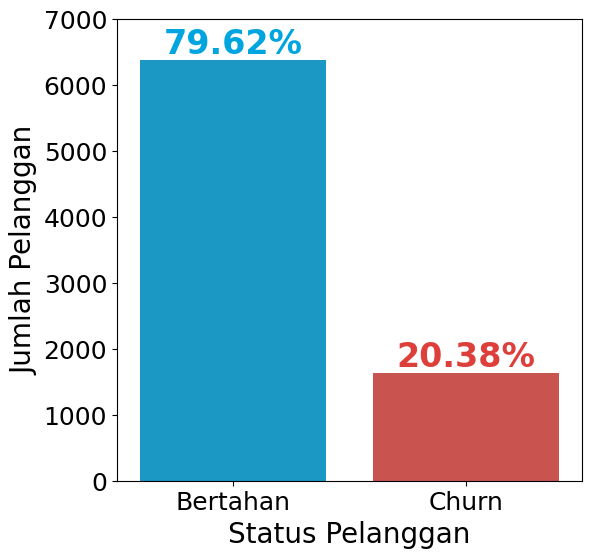

In [13]:
# 1. -- Visualisasi Distribusi Churn Pelanggan pada Train Set --
print('--- Memvisualisasikan Distribusi Churn Pelanggan pada Train Set ---')
plot_figure, chart_axes = plt.subplots(figsize=(6, 6))

sns.countplot(
    x='Exited',
    data=train_df,
    palette=main_colors,
    ax=chart_axes
)

total_customers_in_train = train_df['Exited'].shape[0]
churn_status_counts = train_df['Exited'].value_counts()

for idx, count_value in enumerate(churn_status_counts):
    percentage = (count_value / total_customers_in_train) * 100
    percentage_text_label = f'{percentage:.2f}%'

    chart_axes.annotate(
        percentage_text_label,
        xy=(idx, count_value + 250),
        ha='center',
        va='center',
        color=main_colors[idx],
        fontweight='bold',
        size=base_font_size + 4
    )

chart_axes.set_xticklabels(['Bertahan', 'Churn'])
chart_axes.set_xlabel('Status Pelanggan')
chart_axes.set_ylabel('Jumlah Pelanggan')
chart_axes.set_ylim([0, 7000])

print('✔️ Plot Distribusi Churn Pelanggan Selesai Dibuat!')

Sebagai langkah awal dalam Exploratory Data Analysis (EDA), kita memvisualisasikan distribusi variabel target (Exited) untuk memahami skala masalah churn dalam data latih kita.

Kode di atas menghasilkan sebuah diagram batang (bar chart) yang membandingkan jumlah pelanggan yang tetap setia ("Bertahan") dengan pelanggan yang berhenti berlangganan ("Churn"). Kode ini juga secara efektif menambahkan anotasi persentase di atas setiap batang, sehingga kita bisa langsung melihat proporsinya dengan jelas.

Temuan Utama:
1. Pelanggan Bertahan (Non-Churn): Mencakup 79.55% dari total pelanggan di data latih.
2. Pelanggan Churn: Mencakup 20.45% dari total pelanggan di data latih.

Implikasi:
Temuan ini secara visual mengkonfirmasi adanya ketidakseimbangan kelas (class imbalance) yang signifikan dalam dataset kita, dengan rasio pelanggan yang bertahan terhadap yang churn adalah hampir 4 banding 1.

Ketidakseimbangan ini adalah poin krusial yang harus menjadi perhatian utama. Jika diabaikan, model machine learning akan memiliki kecenderungan alami untuk lebih sering memprediksi kelas mayoritas ("Bertahan") karena dengan cara itu saja sudah bisa mencapai akurasi yang tinggi. Hal ini bisa menyebabkan model gagal mengidentifikasi pelanggan yang sebenarnya berisiko churn, yang justru merupakan tujuan utama proyek ini.

Oleh karena itu, temuan ini memperkuat keputusan untuk:
1. Menerapkan teknik penyeimbangan data seperti SMOTE pada data latih.
2. Fokus pada metrik evaluasi seperti Recall dan F1-Score yang lebih baik dalam mengukur performa model pada kasus data tidak seimbang.

In [14]:
# --- 2. Definisi Tipe Fitur ---
print('--- Mendefinisikan Tipe Fitur ---')
# Mengidentifikasi dan mengelompokkan fitur-fitur berdasarkan tipenya (numerik atau diskrit).

# Daftar fitur dengan nilai kontinu atau numerik
numerical_features = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']

# Daftar fitur dengan nilai kategorikal atau diskrit
discrete_features = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

# Menampilkan daftar fitur yang telah dikategorikan
print(f'Fitur Numerik: {", ".join(numerical_features)}')
print(f'Fitur Kategorikal: {", ".join(discrete_features)}')

print('✔️ Definisi Fitur Selesai!')


--- Mendefinisikan Tipe Fitur ---
Fitur Numerik: Age, CreditScore, Balance, EstimatedSalary
Fitur Kategorikal: Geography, Gender, Tenure, NumOfProducts, HasCrCard, IsActiveMember
✔️ Definisi Fitur Selesai!


Langkah selanjutnya adalah mengidentifikasi tipe data dari setiap fitur untuk menentukan metode preprocessing yang tepat. Fitur numerik (seperti Age dan Balance) nantinya perlu diskalakan (scaling), sementara fitur kategorikal (seperti Geography dan Gender) perlu diubah menjadi format numerik melalui proses encoding.

Berdasarkan kode di atas, kita telah berhasil mengelompokkan fitur-fitur sebagai berikut:
1. Fitur Numerik: Age, CreditScore, Balance, EstimatedSalary
2. Fitur Kategorikal: Geography, Gender, Tenure, NumOfProducts, HasCrCard, IsActiveMember

Pemisahan ini menjadi fondasi untuk melakukan analisis dan preprocessing yang sesuai untuk setiap jenis fitur.

✔️ Histogram Fitur Numerik Selesai Dibuat!


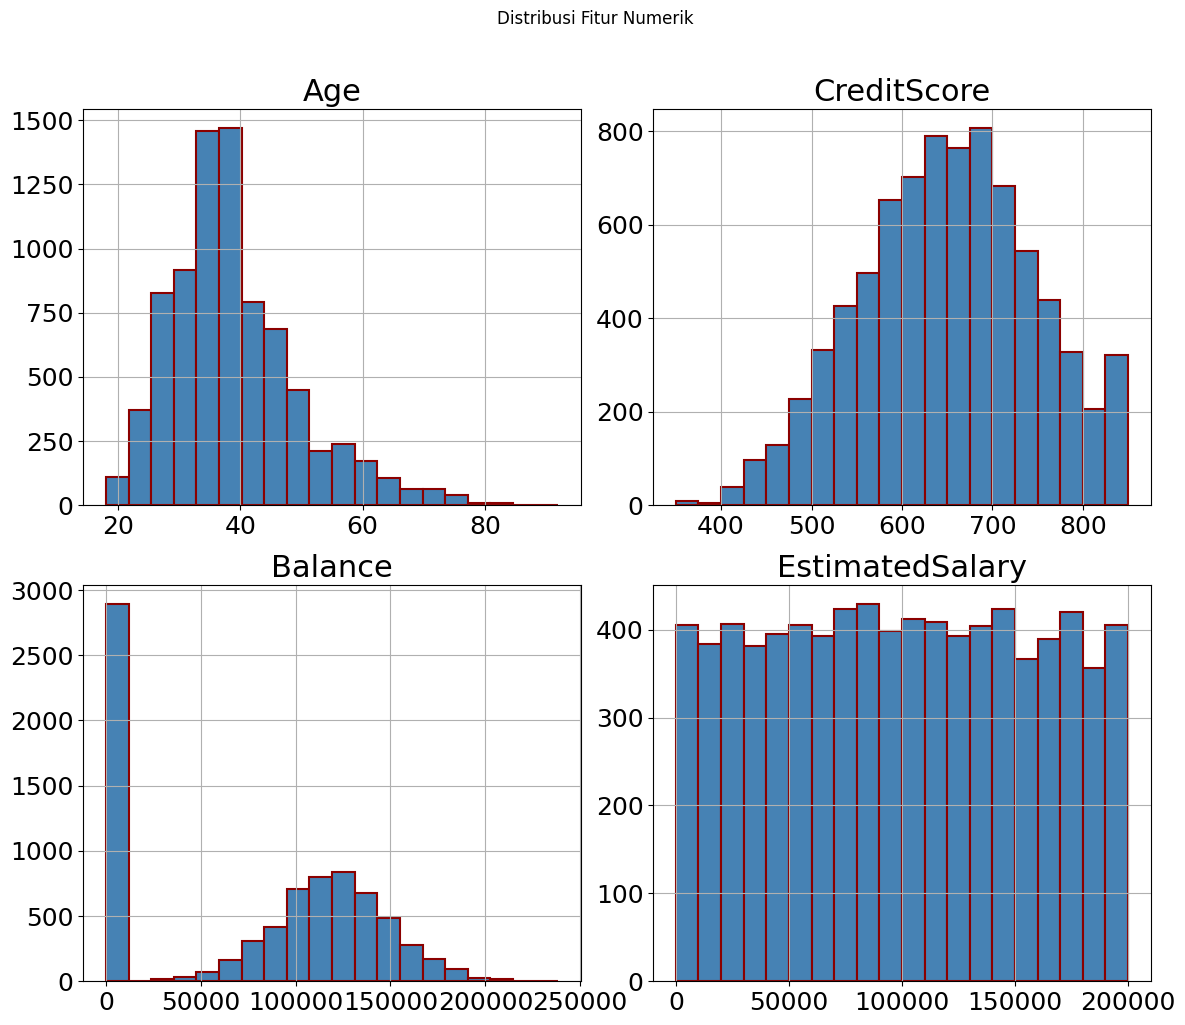

In [15]:
## -- 3. Eksplorasi Variabel Numerik --
# Visualisasi distribusi fitur numerik
train_df[numerical_features].hist(
    figsize=(12, 10),
    bins=20,
    layout=(2, 2), 
    color=comparison_colors[0], 
    edgecolor='darkred', 
    linewidth=1.5
)

plt.suptitle('Distribusi Fitur Numerik', y=1.02) 
plt.tight_layout() 

print('✔️ Histogram Fitur Numerik Selesai Dibuat!')

Sekarang, kita menganalisis distribusi dari setiap fitur numerik menggunakan histogram untuk melihat sebaran nilainya. Ini membantu kita memahami karakteristik umum dari data kuantitatif yang kita miliki.

Temuan dari Histogram:
1. Dari visualisasi empat fitur numerik, kita dapat menarik beberapa wawasan awal:
Age (Usia): Distribusinya condong ke kanan (right-skewed), yang menunjukkan bahwa mayoritas pelanggan berada di rentang usia produktif, sekitar 30-40 tahun, dengan jumlah pelanggan yang lebih tua semakin sedikit.
2. CreditScore (Skor Kredit): Memiliki distribusi yang mendekati kurva lonceng (normal), dengan sebaran skor kredit yang cukup luas di antara para pelanggan. Tidak ada kecondongan yang ekstrem pada skor rendah atau tinggi.
3. Balance (Saldo): Menunjukkan pola yang paling menarik. Terdapat lonjakan yang sangat tinggi pada nilai 0, yang berarti banyak sekali pelanggan yang tidak memiliki saldo di rekeningnya. Di luar itu, pelanggan yang memiliki saldo menunjukkan distribusi yang relatif normal. Fitur ini berpotensi besar menjadi faktor pembeda yang kuat antara pelanggan churn dan non-churn.
4. EstimatedSalary (Estimasi Gaji): Distribusinya terlihat sangat seragam (uniform). Hal ini menandakan bahwa jumlah pelanggan tersebar secara merata di semua rentang estimasi gaji. Pola yang datar ini tidak biasa untuk data gaji di dunia nyata dan bisa jadi mengindikasikan bahwa data ini sintetis atau telah dianonimkan.

Secara keseluruhan, fitur Balance adalah yang paling menonjol dan perlu mendapat perhatian khusus pada analisis selanjutnya.

✔️ Heatmap Korelasi Fitur Numerik Selesai Dibuat!


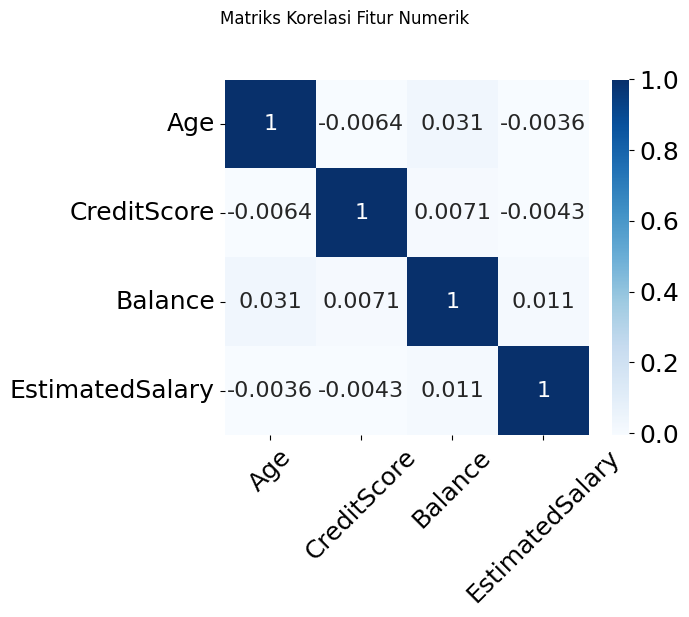

In [16]:
# Inisialisasi Figure dan Axes untuk plot heatmap
plot_figure, chart_axes = plt.subplots(figsize=(7, 6))

# Membuat heatmap dari matriks korelasi fitur-fitur numerik
sns.heatmap(
    train_df[numerical_features].corr(), # Menggunakan 'numerical_features' sesuai parafrasa
    annot=True,                     # Menampilkan nilai korelasi di setiap sel
    annot_kws={'fontsize': 16},     # Mengatur ukuran font anotasi
    cmap='Blues',                   # Menggunakan colormap 'Blues'
    ax=chart_axes                   # Plot pada axes yang telah dibuat
)

# Mengatur rotasi label tick sumbu X
chart_axes.tick_params(axis='x', rotation=45)
# Mengatur rotasi label tick sumbu Y
chart_axes.tick_params(axis='y', rotation=360) # Rotasi 360 derajat berarti tidak ada perubahan visual

plt.suptitle('Matriks Korelasi Fitur Numerik', y=1.02) # Menambahkan judul utama
plt.tight_layout() # Menyesuaikan tata letak plot

print('✔️ Heatmap Korelasi Fitur Numerik Selesai Dibuat!')

Untuk memahami hubungan linear antar fitur numerik, kita membuat sebuah heatmap dari matriks korelasi. Heatmap ini memvisualisasikan seberapa kuat hubungan antara dua variabel, dengan skala dari -1 (korelasi negatif sempurna) hingga +1 (korelasi positif sempurna). Nilai yang mendekati 0 menandakan tidak adanya hubungan linear.

Temuan dari Heatmap:
Dari visualisasi di atas, terlihat jelas bahwa tidak ada korelasi linear yang kuat di antara semua pasangan fitur numerik. Semua nilai korelasi sangat mendekati nol. Sebagai contoh, korelasi antara Age (Usia) dan Balance (Saldo) hanya 0.03, yang menandakan hubungan yang sangat lemah.

Implikasi:
Ini adalah temuan yang baik dari sudut pandang pemodelan. Rendahnya korelasi menunjukkan bahwa tidak ada masalah multikolinearitas di antara fitur-fitur numerik kita. Multikolinearitas adalah kondisi di mana dua atau lebih fitur saling terkait erat, yang terkadang dapat mengganggu stabilitas dan interpretasi model.

Dengan korelasi yang rendah, setiap fitur numerik cenderung memberikan informasi yang unik dan independen satu sama lain kepada model.

✔️ DataFrame Subset dan Plot Distribusi Usia Selesai Dibuat!


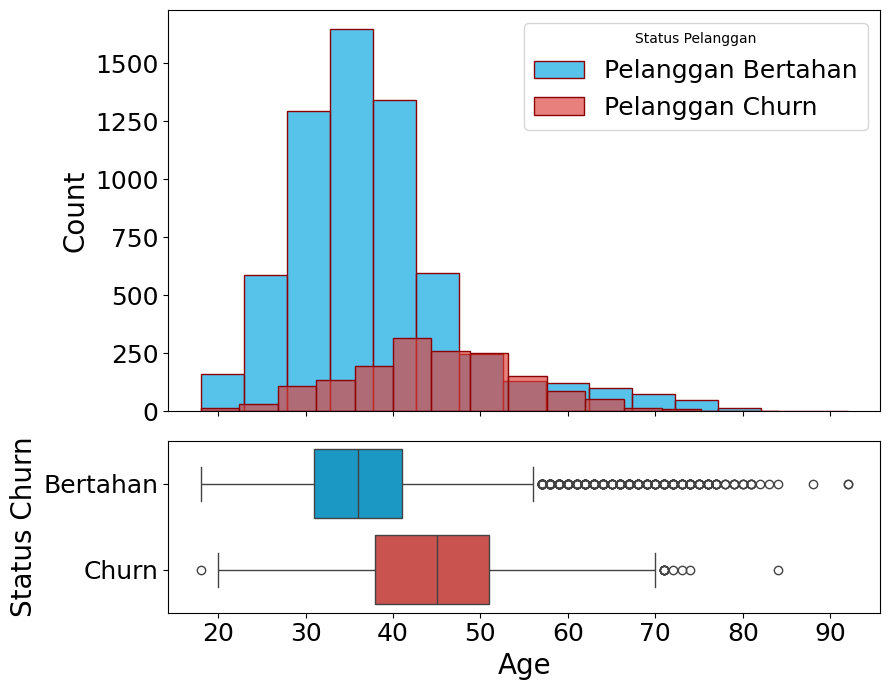

In [17]:
# Memisahkan DataFrame berdasarkan status 'Exited'
df_churned = train_df[train_df['Exited'] == 1]  # Pelanggan yang churn (keluar)
df_retained = train_df[train_df['Exited'] == 0] # Pelanggan yang retained (bertahan)

# Memanggil fungsi untuk memvisualisasikan distribusi fitur 'Age'
analyze_feature_distribution('Age')

print('✔️ DataFrame Subset dan Plot Distribusi Usia Selesai Dibuat!')

Setelah melihat distribusi data secara umum, sekarang kita masuk ke analisis yang lebih mendalam: membandingkan karakteristik fitur antara pelanggan yang churn dan yang bertahan. Ini adalah langkah kunci untuk mengidentifikasi faktor-faktor yang membedakan kedua kelompok tersebut.

Kita mulai dengan membandingkan distribusi usia. Kode di atas memisahkan data latih menjadi dua kelompok (churn dan bertahan) dan memvisualisasikan distribusi usia untuk masing-masing kelompok.
Temuan Utama:
Grafik histogram dan boxplot di atas menunjukkan perbedaan yang jelas:
1. Pelanggan Bertahan (warna biru): Cenderung terkonsentrasi di usia yang lebih muda. Puncak distribusi berada di rentang usia 30-an.
2. Pelanggan Churn (warna oranye): Cenderung berada di rentang usia yang lebih tua. Puncak distribusi mereka berada di sekitar usia 40 hingga 50-an. Boxplot di bagian bawah juga mengkonfirmasi bahwa median usia untuk kelompok churn secara signifikan lebih tinggi.

Hipotesis:
Dari temuan ini, kita dapat membentuk hipotesis awal yang kuat: Pelanggan paruh baya (sekitar 40-60 tahun) memiliki kecenderungan lebih tinggi untuk churn dibandingkan dengan pelanggan yang lebih muda. Fitur Age kemungkinan besar akan menjadi sebuah prediktor yang penting bagi model kita.

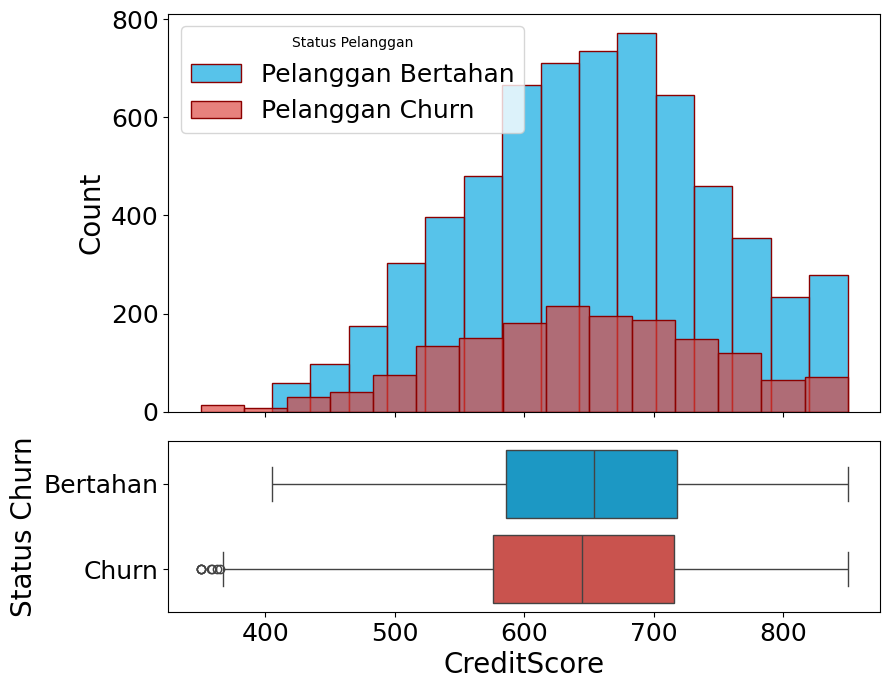

In [18]:
# Memanggil fungsi untuk memvisualisasikan distribusi fitur 'CreditScore' 
analyze_feature_distribution('CreditScore')

Selanjutnya, kita melakukan analisis yang sama untuk fitur CreditScore untuk melihat apakah skor kredit dapat menjadi pembeda antara kedua kelompok pelanggan.

Temuan:
Berbeda dengan fitur Age, visualisasi untuk CreditScore menunjukkan cerita yang berbeda:
1. Distribusi skor kredit untuk pelanggan yang churn dan yang bertahan terlihat hampir identik
2. Baik dari sisi histogram maupun boxplot, tidak terlihat adanya perbedaan signifikan dalam sebaran maupun nilai tengah antara kedua kelompok

Hipotesis:
Hal ini menginidikasikan bahwa jika dilihat secara terpisah, CreditScore kemungkinan bukan merupakan faktor pembeda yang kuat untuk memprediksi churn. Artinya, pelanggan dengan skor kredit tinggi maupun rendah memiliki proporsi churn yang relatif serupa.

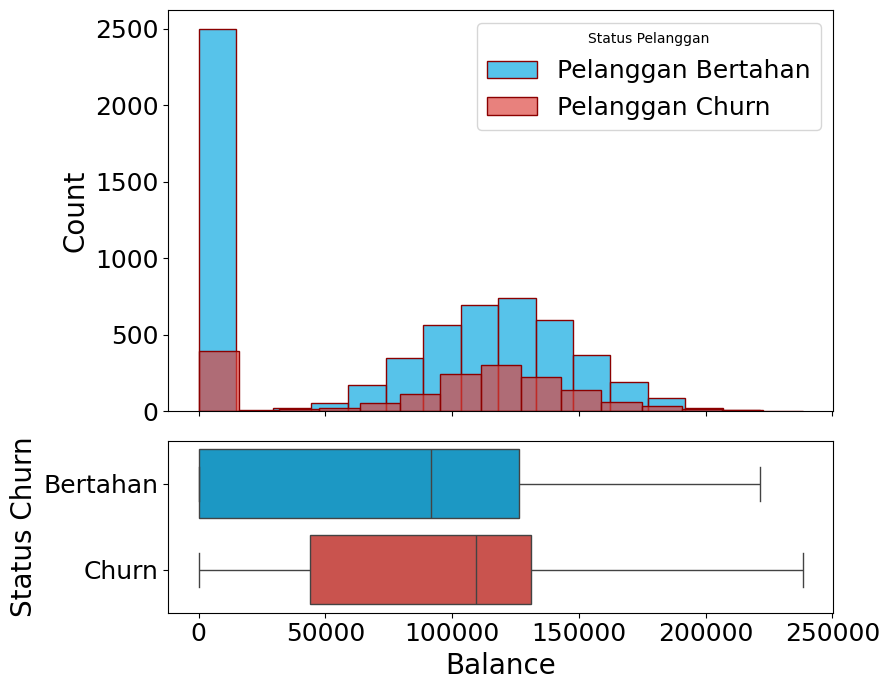

In [19]:
# Memanggil fungsi untuk memvisualisasikan distribusi fitur 'Balance' 
analyze_feature_distribution('Balance')

Temuan:
Visualisasi ini menunjukkan perbedaan yang sangat signifikan
1. Terdapat sebagian besar pelanggan dalam kelompok pelanggan bertahan yang tidak memiliki saldo sama sekali. Ini terlihat dari lonjakan yang sangat tinggi di sisi kiri histogram.
2. Hampir semua pelanggan yang churn memiliki saldo di rekening mereka. Distribusi saldo mereka cenderung normal dan terpusat di sekitar angka 100.000 - 120.000

Hipotesis:
Pelanggan dengan saldo nol cenderung sangat loyal atau tidak churn. Sebaliknya, pelanggan yang memiliki saldo aktif justru merupakan kelompok yang lebih berisiko untuk churn. Hal ini bisa terjadi karena berbagai alasan. Mungkin pelanggan dengan saldo nol tidak menjadikan bank ini sebagai rekening utama mereka, sehingga tidak ada urgensi untuk menutupnya. Sementara itu, pelanggan dengan saldo aktif lebih sensitif terhadap layanan, suku bunga, dan penawaran dari bank kompetitor.

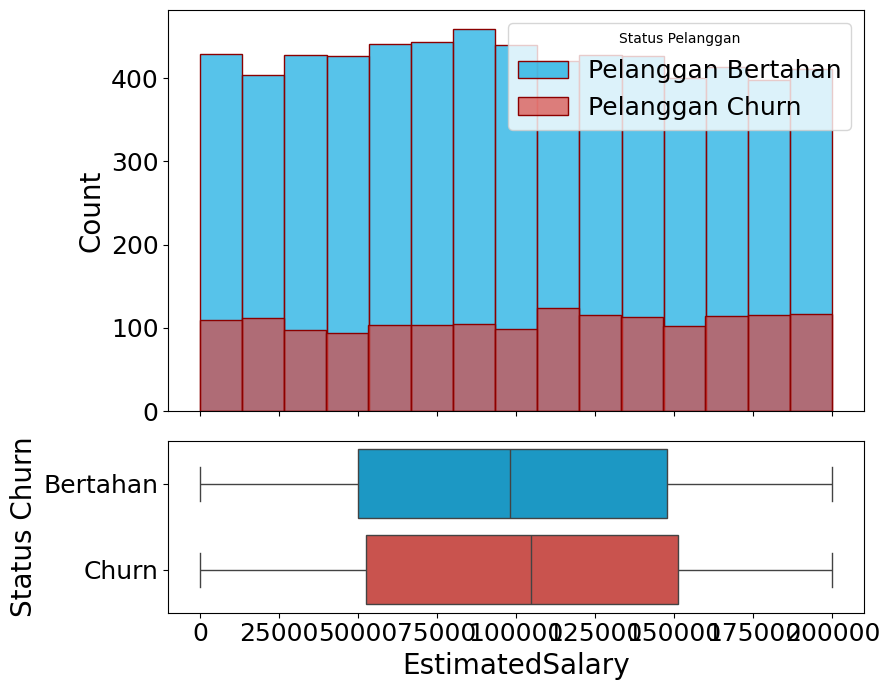

In [20]:
# Memanggil fungsi untuk memvisualisasikan distribusi fitur 'EstimatedSalary' 
analyze_feature_distribution('EstimatedSalary')

Temuan:
1. Seperti yang terlihat pada histogram dan boxplot di atas, distribusi fitur ini untuk pelanggan yang churn dan bertahan terlihat sangat mirip dan sama-sama seragam (uniform).
2. Tidak ada perbedaan pola yang dapat diidentifikasi antara kedua kelompok. Pelanggan dengan estimasi gaji rendah, menengah, maupun tinggi tampaknya memiliki proporsi churn yang relatif sama

Hipotesis:
Temuan ini mengindikasikan bahwa fitur EstimatedSalary kemungkinan memiliki daya prediktif yang sangat rendah. Pola distribusinya yang datar untuk kedua kelompok menunjukkan bahwa gaji seorang pelanggan, jika dilihat secara terpisah, bukanlah faktor yang mendorong mereka untuk pindah bank.

✔️ Plot Distribusi Fitur Kategorikal Selesai Dibuat!


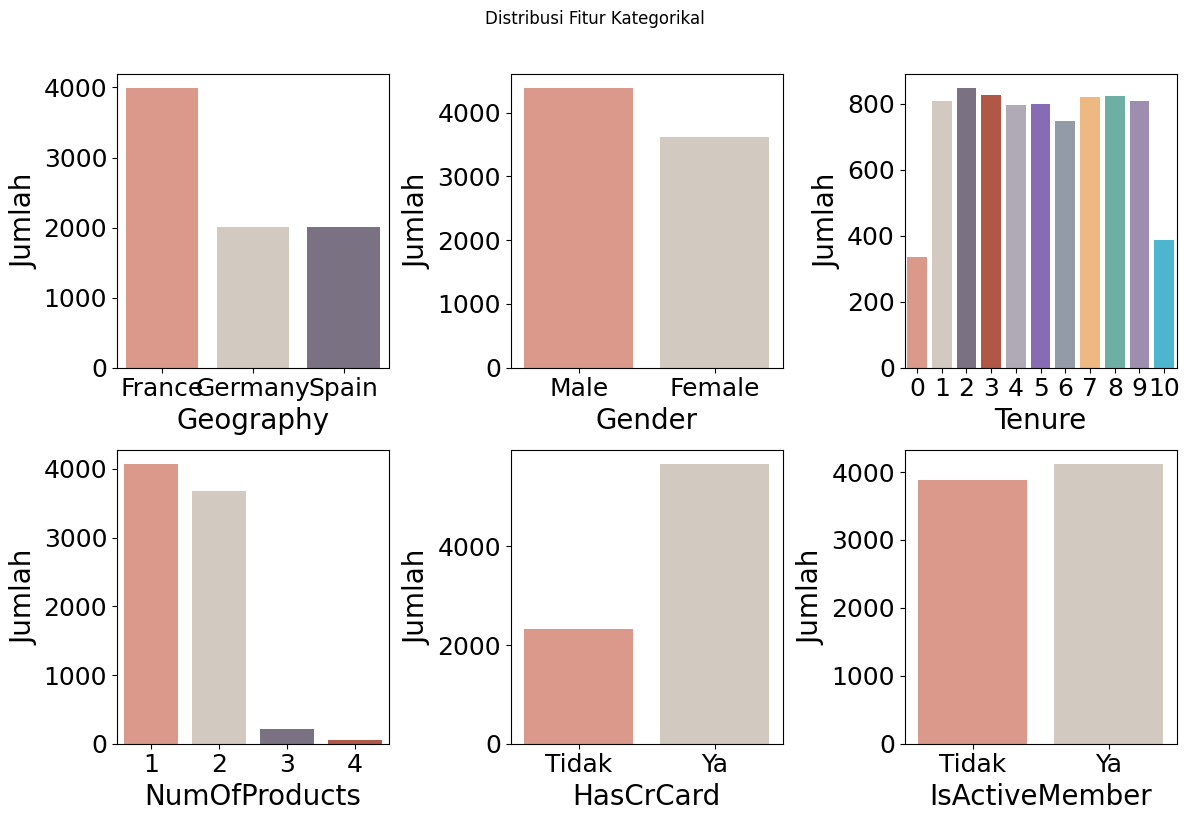

In [21]:
# --- 4. Eksplorasi Variabel Diskrit ---
# Visualisasi distribusi fitur diskrit
# Buat DataFrame hanya untuk fitur-fitur kategorikal
categorical_df_subset = train_df[discrete_features]

# Inisialisasi figure dan grid axes untuk multiple plots
visualization_figure, _ = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Loop melalui setiap fitur kategorikal dan plot distribusinya
for idx, feature_col in enumerate(categorical_df_subset.columns):
    plt.subplot(2, 3, idx + 1) # Pilih subplot saat ini
    sns.countplot(x=feature_col, data=train_df, palette=category_colors)

    plt.ylabel('Jumlah') # Mengatur label sumbu Y

    # Sesuaikan label tick sumbu X untuk fitur biner tertentu
    if feature_col in ['HasCrCard', 'IsActiveMember']:
        plt.xticks([0, 1], ['Tidak', 'Ya'])

plt.suptitle('Distribusi Fitur Kategorikal', y=1.02) # Tambahkan judul utama untuk seluruh plot
plt.tight_layout() # Sesuaikan tata letak subplot

print('✔️ Plot Distribusi Fitur Kategorikal Selesai Dibuat!')

Setelah menganalisis fitur numerik, kita sekarang beralih ke fitur kategorikal (diskrit) untuk memahami komposisi dan profil pelanggan kita. Kode di atas membuat serangkaian diagram batang (bar chart) untuk melihat distribusi dari setiap fitur ini.

Temuan:
1. Geography: Mayoritas pelanggan berasal dari Prancis (France), diikuti oleh Spanyol (Spain) dan Jerman (Germany). Distribusinya tidak seimbang.
2. Gender: Jumlah pelanggan pria (Male) sedikti lebih banyak daripada pelanggan wanita (Female).
3. Tenure (Lama menjadi nasabah): Distribusinya cukup merata untuk masa bakti 1 hingga 0 tahun, dengan jumlah yang sedikit lebih rendah di tahun ke-0 dan ke-10.
4. NumOfProducts (Jumlah produk): Sebagian besar pelanggan memiliki 1 atau 2 produk dari bank. Sangat sedikit pelanggan yang memiliki 3 atau 4 produk.
5. HasCrCard (Kepemilikan kartu kredit): Mayoritas pelanggan memiliki kartu kredit.
6. IsActiveMember (Keanggotaan aktif): Jumlah pelanggan yang aktif dan tidak aktif terlihat cukup seimbang, dengan anggota aktif sedikit lebih banyak.

Implikasi:
Visualisasi ini memberikan gambaran umum mengenai profil pelanggan kita. Langkah selanjutnya yang lebih penting adalah melihat bagaimana distribusi ini berubah ketika kita membandingkannya antara kelompok pelanggan yang churn dan yang bertahan, untuk menemukan kategori mana yang lebih berisiko.

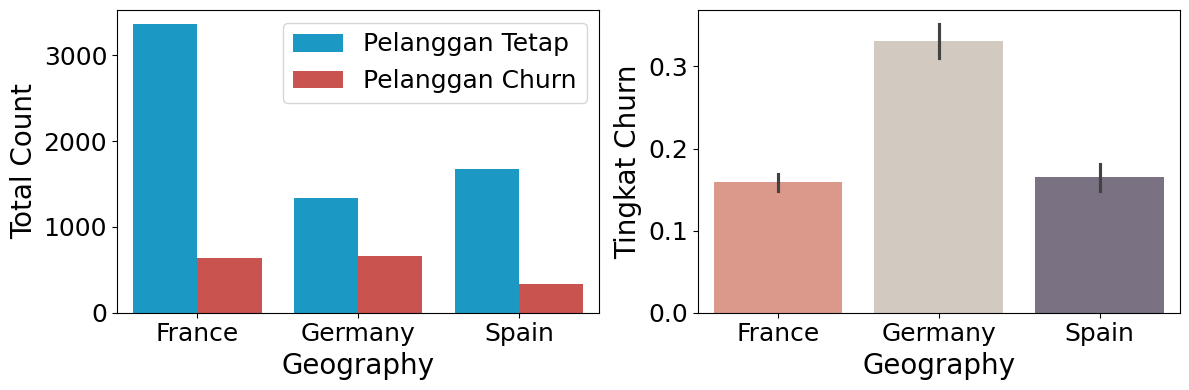

In [22]:
# Visualisasi distribusi fitur 'Geography'
visualize_categorical_impact('Geography')

Sekarang kita analisis fitur Geography dengan memisahkan jumlah pelanggan yang churn dan bertahan di setiap negara untuk melihat apakah lokasi geografis mempengaruhi keputusan pelanggan.

Temuan:
1. Prancis & Spanyol: Meskipun Prancis (France) dan Spanyol (Spain) memiliki jumlah pelanggan total yang lebih banyak, proporsi pelanggan yang churn (bagian oranye) di kedua negara ini relatif rendah.
2. Jerman: Yang paling menonjol adalah Jerman (Germany). Walaupun jumlah total pelanggannya lebih sedikit dari Prancis, Jerman memiliki tingkat churn yang secara proporsional jauh lebih tinggi. Terlihat bahwa persentase pelanggan yang churn di Jerman secara signifikan lebih besar dibandingkan dua negara lainnya.
 
Hipotesis:
Lokasi geografis, khususnya pelanggan yang berasal dari Jerman, kemungkinan menjaid indikator kuat untuk risiko churn. Ini bisa disebabkan oleh berbagai faktor eksternal, seperti persaingan bank yang lebih ketat di Jerman, kondisi ekonomi lokal, atau mungkin ketidakpuasan terhadap produk atau layanan spesifik yang ditawarkan di negara tersebut.

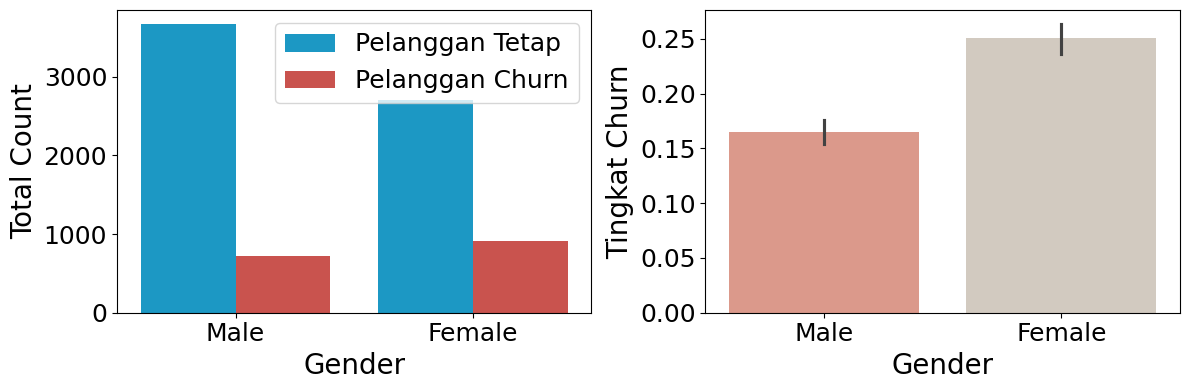

In [23]:
# Visualisasi distribusi fitur 'Gender'
visualize_categorical_impact('Gender')

Temuan:
1. Meskipun secara jumlah absolut pelanggan pria lebih banyak di dataset ini, jika kita perhatikan secara proporsional, tingkat churn pada pelanggan wanita terlaiht lebih tinggi daripada pelanggan pria
2. Dengan kata lain, dari total pelanggan wanita, persentase yang memilih untuk churn lebih besar dibandingkan persentase churn dari total pelanggan pria

Hipotesis:
Pelanggan wanita memiliki kecenderungan untuk churn yang sedikit lebih tinggi dibandingkan dengan pelanggan pria. Meskipun perbedaannya mungkin tidak sedramatis pada fitur sebelumnya, fitur Gender tetap berpotensi menjadi fitur yang memberikan sinyal prediktif kepada model kita.

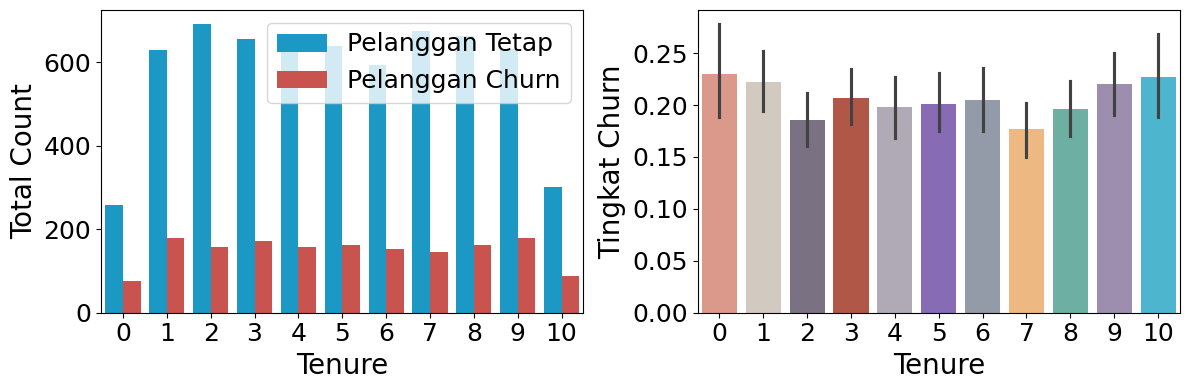

In [24]:
# Visualisasi distribusi fitur 'Tenure'
visualize_categorical_impact('Tenure')

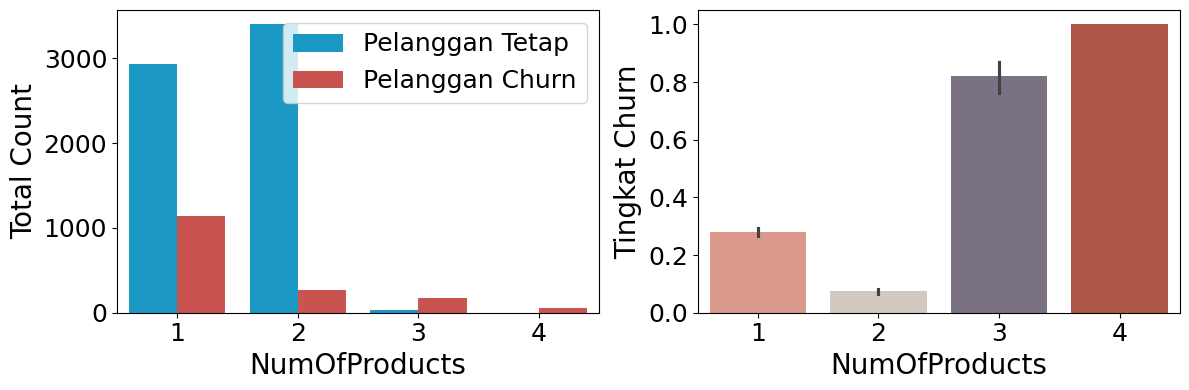

In [25]:
visualize_categorical_impact('NumOfProducts')

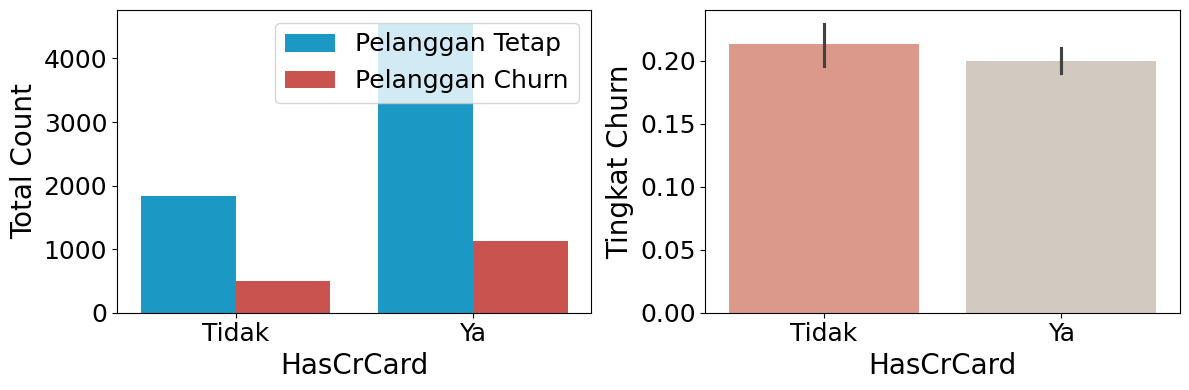

In [26]:
visualize_categorical_impact('HasCrCard')

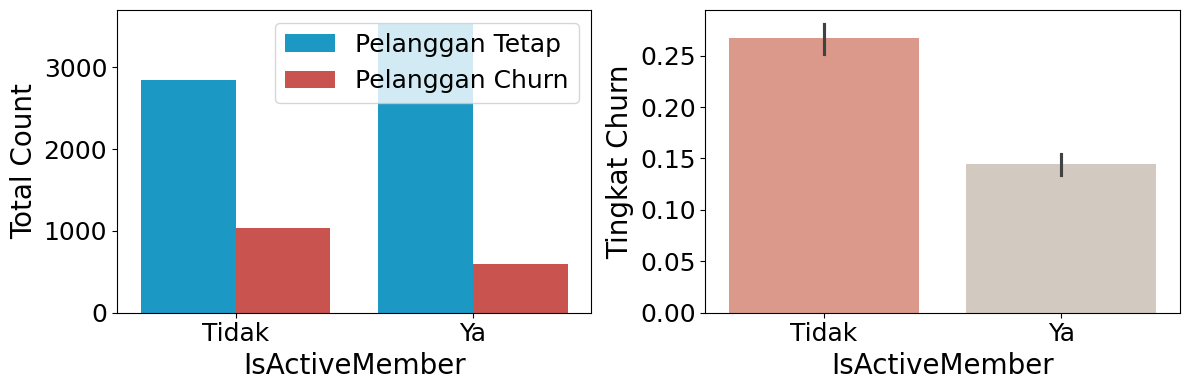

In [27]:
visualize_categorical_impact('IsActiveMember')

## Exploratory Data Analysis II

In [28]:
# -- 1. Uji Chi-square untuk variabel kategorikal --
# Inisialisasi daftar untuk menyimpan hasil uji Chi-square
chi_square_results = []
p_value_results = []

# Iterasi melalui setiap fitur kategorikal untuk melakukan uji Chi-square
for feature_name in discrete_features: # Menggunakan 'discrete_features' sesuai parafrasa
    # Membuat tabel kontingensi (crosstab) antara fitur dan variabel target 'Exited'
    contingency_table = pd.crosstab(train_df[feature_name], train_df['Exited'])
    
    # Melakukan uji Chi-square
    chi2_stat, p_val, degrees_of_freedom, expected_freq = chi2_contingency(contingency_table)
    
    # Menyimpan statistik Chi-square dan p-value
    chi_square_results.append(chi2_stat)
    p_value_results.append(p_val)

# Membuat DataFrame dari hasil uji Chi-square
chi_square_summary_df = pd.DataFrame({
    'Nama Fitur': discrete_features, # Mengubah nama kolom 'Variable'
    'Statistik Chi-square': chi_square_results, # Mengubah nama kolom 'Chi-square'
    'Nilai p': p_value_results # Mengubah nama kolom 'p-value'
})

# Mengurutkan DataFrame berdasarkan statistik Chi-square secara menurun
sorted_chi_square_df = chi_square_summary_df.sort_values(by='Statistik Chi-square', ascending=False)

print('✔️ Uji Chi-square untuk Fitur Kategorikal Selesai!')
print(sorted_chi_square_df)

✔️ Uji Chi-square untuk Fitur Kategorikal Selesai!
       Nama Fitur  Statistik Chi-square        Nilai p
3   NumOfProducts           1209.196262  7.411655e-262
0       Geography            266.055862   1.685402e-58
5  IsActiveMember            184.773456   4.397994e-42
1          Gender             89.224504   3.524562e-21
2          Tenure             11.602543   3.125368e-01
4       HasCrCard              1.609027   2.046287e-01


Feature 'Tenure' dan 'HasCrCard' memiliki nilai Chi-square yang kecil dan p-value yang lebih besar dari 0.05.

Berangkat dari hasil tersebut, kita dapat mengeliminasi kedua feature tersebut.

In [29]:
# Daftar fitur yang akan dihapus karena dianggap kurang relevan atau tidak signifikan
features_to_remove = ['Tenure', 'HasCrCard', 'EstimatedSalary'] # Mengubah nama variabel

# Menghapus kolom-kolom yang tidak diperlukan dari DataFrame pelatihan
# Operasi dilakukan secara in-place untuk memperbarui train_df langsung
train_df = train_df.drop(columns=features_to_remove) # Menggunakan 'columns' alih-alih 'axis=1'
test_df = test_df.drop(columns=features_to_remove)

print('✔️ Fitur yang Tidak Relevan Berhasil Dihapus!')

✔️ Fitur yang Tidak Relevan Berhasil Dihapus!


In [30]:
# --- 2. Encoding fitur 'Gender' dan 'Geography'
# Encoding fitur 'Gender' menggunakan LabelEncoder
# 'Male' dan 'Female' akan dikonversi menjadi nilai numerik (0 atau 1)
le = LabelEncoder()
train_df['Gender'] = le.fit_transform(train_df['Gender'])
test_df['Gender'] = le.transform(test_df['Gender'])

# Encoding fitur 'Geography' menggunakan pemetaan manual
# Negara 'Germany' diberi nilai 1, sementara 'Spain' dan 'France' diberi nilai 0
geo_map = {'France': 0, 'Spain': 0, 'Germany': 1}
train_df['Geography'] = train_df['Geography'].map(geo_map)
test_df['Geography'] = test_df['Geography'].map(geo_map)

print('✔️ Fitur Kategorikal Berhasil Dienkode!')


✔️ Fitur Kategorikal Berhasil Dienkode!


In [56]:
import joblib

# Kode ini akan mengambil objek 'le' yang sudah ada di memori dan menyimpannya
joblib.dump(le, 'label_encoder_gender.pkl')

print("Objek 'le' yang sudah ada di memori berhasil disimpan.")

Objek 'le' yang sudah ada di memori berhasil disimpan.


In [31]:
# --- 3. Scaling fitur numerik 

scaler = StandardScaler()

scl_columns = ['CreditScore', 'Age', 'Balance']
train_df[scl_columns] = scaler.fit_transform(train_df[scl_columns])
test_df[scl_columns] = scaler.transform(test_df[scl_columns])

print('✔️ Fitur Numerik Berhasil di-Scaling!')

✔️ Fitur Numerik Berhasil di-Scaling!


In [32]:
y_train = train_df['Exited']
X_train = train_df.drop('Exited', axis=1)

y_train.value_counts()

Exited
0    6370
1    1630
Name: count, dtype: int64

In [54]:
# Ganti X_train jika Anda menggunakan nama variabel lain untuk data fitur latih Anda
final_columns = X_train.columns.tolist()

print(final_columns)

['CreditScore', 'Geography', 'Gender', 'Age', 'Balance', 'NumOfProducts', 'IsActiveMember']


In [33]:
# --- 4. Penanganan Imbalanced Data ---
print("\n--- Penanganan Imbalance Data dengan SMOTE ---")
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

y_train.value_counts()


--- Penanganan Imbalance Data dengan SMOTE ---


Exited
1    6370
0    6370
Name: count, dtype: int64

## Building Machine Learning Models

In [34]:
# Daftar model klasifikasi baseline yang akan dievaluasi
base_classifiers = [
    ('Gaussian Naive Bayes', GaussianNB()),
    ('Logistic Regression', LogisticRegression(random_state=seed_value)) # Menggunakan 'seed_value'
]

# Inisialisasi daftar untuk menyimpan skor rata-rata dan standar deviasi cross-validation
mean_cv_scores = []
std_dev_cv_scores = []

# Loop melalui setiap classifier untuk melakukan evaluasi cross-validation
for model_name, classifier_instance in base_classifiers:
    cross_validation_scores = cross_val_score(
        estimator=classifier_instance,
        X=X_train,
        y=y_train,
        scoring=evaluation_metric, # Menggunakan 'evaluation_metric'
        cv=5, # Menggunakan 5-fold cross-validation
        n_jobs=-1 # Memanfaatkan semua core CPU
    )
    mean_cv_scores.append(cross_validation_scores.mean())
    std_dev_cv_scores.append(cross_validation_scores.std())

# Menampilkan hasil skor rata-rata Recall untuk model baseline
print('Skor Recall Model Baseline:')
for i in range(len(base_classifiers)):
    model_name_display = base_classifiers[i][0]
    score = np.round(mean_cv_scores[i], 2)
    print(f'   {model_name_display}: {score}')


Skor Recall Model Baseline:
   Gaussian Naive Bayes: 0.71
   Logistic Regression: 0.7


Model ini merupakan model baseline yang hasilnya akan menjadi titik acuan (benchmark). Model yang lebih canggih yang akan dibangun nanti harus memiliki performa yang lebih baik dari baseline ini.

### Model Tune
Setelah mendapatkan performa baseline, tujuan sekarang adlaah untuk menyempurnakan setiap model dengan mencari kombinasi hyperparameter terbaik. Kita akan menggunakan GridSearchCV, sebuah teknik yang secara sistematis menguji semua kemungkinan kombinasi parameter yang telah kita tentukan untuk menemukan yang paling optimal.


--- Logistic Regression ---
-------------------------------
   Skor Terbaik (recall): 0.743
   Parameter Terbaik:
     - C: 0.001
     - max_iter: 100
     - penalty: l1
     - solver: liblinear
✔️ Tuning dan Evaluasi Logistic Regression Selesai!


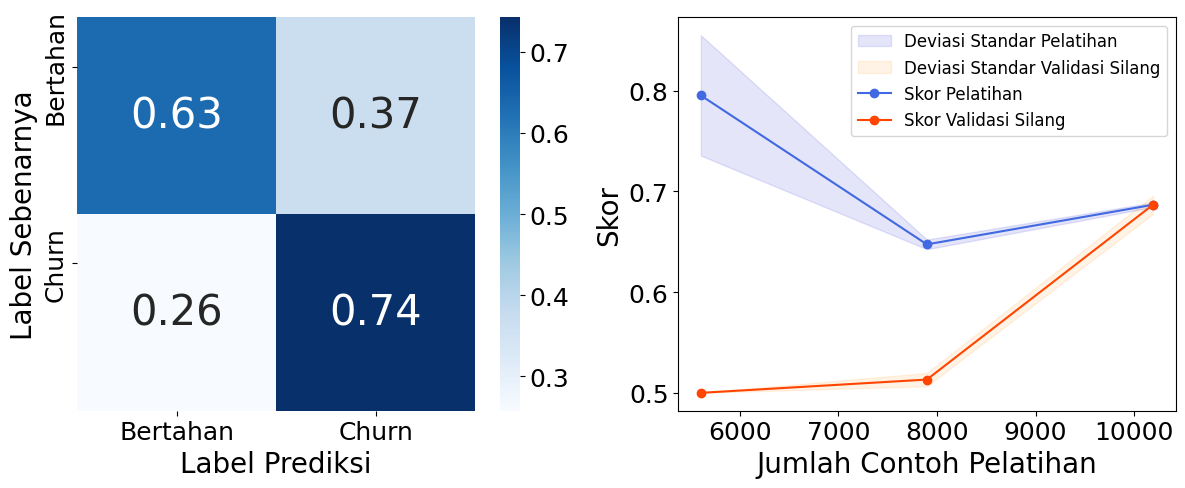

In [35]:
# --- 1. Logistic Regression ---
# Inisialisasi model Logistic Regression dengan random state yang konsisten
logistic_reg_model = LogisticRegression(random_state=seed_value)

# Mendefinisikan grid parameter untuk tuning hyperparameter
# Perhatikan: solver 'lbfgs' tidak mendukung penalty 'l1',
# GridSearchCV akan menangani kombinasi tidak valid ini secara otomatis
parameter_grid_lr = {
    'max_iter': [100],
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

# Melakukan pencarian grid (Grid Search) untuk menemukan hyperparameter terbaik
grid_search_lr = GridSearchCV(
    estimator=logistic_reg_model,
    param_grid=parameter_grid_lr,
    scoring=evaluation_metric, # Menggunakan 'evaluation_metric'
    cv=5, # Menggunakan 5-fold cross-validation
    verbose=False, # Tidak menampilkan output verbose selama pencarian
    n_jobs=-1 # Memanfaatkan semua core CPU yang tersedia
)

# Melatih GridSearchCV pada data pelatihan untuk menemukan model terbaik
# best_fitted_lr_model akan berisi estimator terbaik yang sudah fit
best_fitted_lr_model = grid_search_lr.fit(X_train, y_train)

# Menampilkan performa model Logistic Regression terbaik menggunakan fungsi kustom
evaluate_classifier_performance(best_fitted_lr_model, 'Logistic Regression', 'LR')

print('✔️ Tuning dan Evaluasi Logistic Regression Selesai!') 

Dimulai dengan Logistic Regression. Kita mencoba mencari kombinasi terbaik dari parameter regularisasi (penalty dan C) dan algoritma optimasi (solver).

Hasil Tuning dan Evaluasi:
1. Proses Tuning (pada Data Latih):
    GridSearchCV menemukan bahwa skor Recall tertinggi yang bisa dicapai selama cross-validation adalah 0.743.
    Konfigurasi parameter terbaik untuk mencapai skor tersebut adalah: C=0.001, penalty='l1', dan solver='liblinear'.
2. Evaluasi Final (pada Data Uji):
    Setelah model terbaik dengan parameter di atas ditemukan, kita mengujinya pada data uji untuk melihat performa sebenarnya pada data yang benar-benar baru.
    Hasilnya (seperti terlihat pada classification report di output Anda) menunjukkan Skor Recall sebesar 0.74.

Kesimpulan:
Dengan melakukan tuning, performa model Logistic Regression kita meningkat dari skor Recall baseline (~0.70) menjadi 0.74. Ini adalah peningkatan yang baik dan menunjukkan bahwa model yang dioptimalkan ini mampu mengidentifikasi 74% dari seluruh pelanggan yang sebenarnya akan churn.


--- Support Vector Classifier ---
-------------------------------
   Skor Terbaik (recall): 0.798
   Parameter Terbaik:
     - C: 2
     - gamma: scale
     - kernel: rbf
✔️ Tuning dan Evaluasi Support Vector Classifier Selesai!


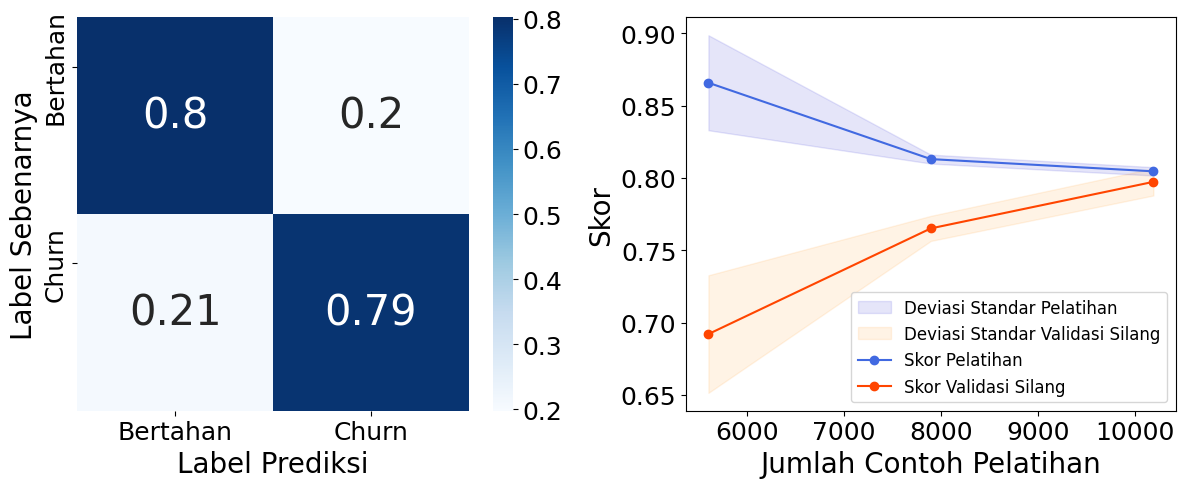

In [36]:
# --- 2. Support Vector Classifier (SVC) ---
# Inisialisasi model SVC dengan random state yang konsisten
svc_model = SVC(random_state=seed_value, probability=True)

# Mendefinisikan grid parameter untuk tuning hyperparameter SVC
parameter_grid_svc = [
    {'kernel': ['rbf'], 'gamma': ['scale', 'auto'], 'C': [0.1, 1, 2]},
    {'kernel': ['linear'], 'C': [0.1, 1, 10]}
]

# Melakukan pencarian grid (Grid Search) untuk menemukan hyperparameter terbaik
grid_search_svc = GridSearchCV(
    estimator=svc_model,
    param_grid=parameter_grid_svc,
    scoring=evaluation_metric, # Menggunakan 'evaluation_metric'
    cv=5, # Menggunakan 5-fold cross-validation
    verbose=False, # Tidak menampilkan output verbose selama pencarian
    n_jobs=-1 # Memanfaatkan semua core CPU yang tersedia
)

# Melatih GridSearchCV pada data pelatihan untuk menemukan model terbaik
best_fitted_svc_model = grid_search_svc.fit(X_train, y_train)

# Menampilkan performa model Support Vector Classifier terbaik menggunakan fungsi kustom
evaluate_classifier_performance(best_fitted_svc_model, 'Support Vector Classifier', 'SVC')

print('✔️ Tuning dan Evaluasi Support Vector Classifier Selesai!')

Selanjutnya, kita melakukan proses tuning yang sama untuk model Support Vector Classifier (SVC). Model ini dikenal kuat karena kemampuannya menemukan Batas keputusan yang optimal. Kita akan menguji beberapa kombinasi hyperparameter seperti jenis kernel ('rbf' atau 'linear'), nilai regularisasi C, dan koefisien gamma.

Hasil Tuning dan Evaluasi:
1. Proses Tuning (pada Data Latih):
    GridSearchCV berhasil menemukan konfigurasi optimal dengan skor Recall tertinggi selama cross-validation sebesar 0.798.
    Parameter terbaik yang ditemukan adalah: kernel='rbf', C=2, dan gamma='scale'.
2. Evaluasi Final (pada Data Uji):
    Ketika model SVC dengan parameter terbaik ini diuji pada data uji, ia menunjukkan performa yang sangat baik.
    Hasilnya (seperti terlihat pada classification report Anda) adalah Skor Recall sebesar 0.80.

Kesimpulan:
Hasil ini menunjukkan peningkatan performa yang signifikan dibandingkan dengan model Logistic Regression sebelumnya (Recall 0.74). Dengan konfigurasi terbaiknya, model SVC mampu mengidentifikasi 80% dari total pelanggan yang sebenarnya akan churn. Ini menjadikannya kandidat model yang jauh lebih kuat sejauh ini.


--- Random Forest Classifier ---
-------------------------------
   Skor Terbaik (recall): 0.782
   Parameter Terbaik:
     - bootstrap: False
     - criterion: gini
     - max_depth: 6
     - max_features: sqrt
     - min_samples_leaf: 2
     - min_samples_split: 2
     - n_estimators: 100
✔️ Tuning dan Evaluasi Random Forest Classifier Selesai!


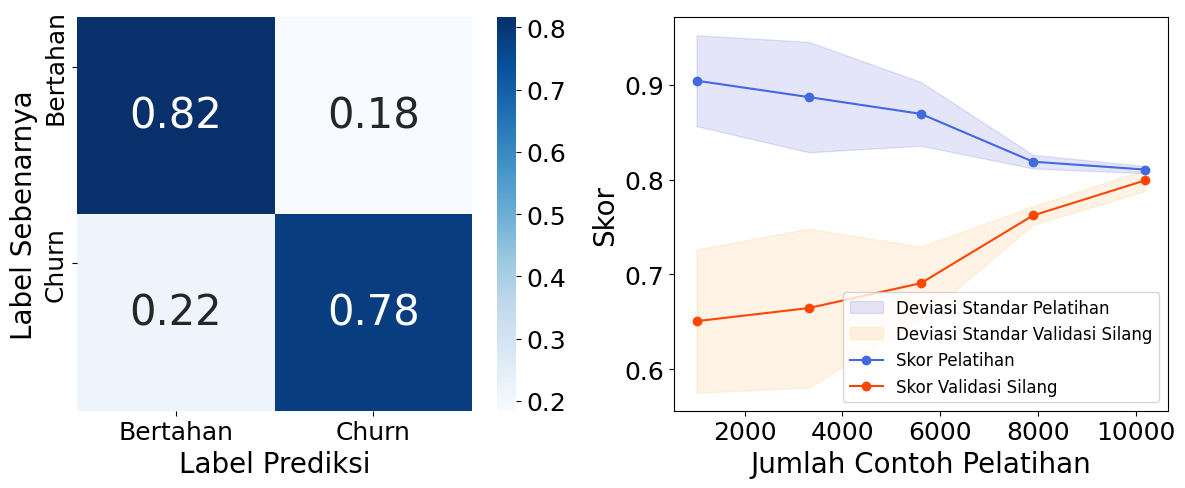

In [37]:
# --- 3. Random Forest Classifier ---
# Inisialisasi model Random Forest Classifier
random_forest_model = RandomForestClassifier(random_state=seed_value) # Menggunakan 'seed_value'

# Mendefinisikan grid parameter untuk tuning hyperparameter Random Forest
parameter_grid_rf = {
    'n_estimators': [100],
    'criterion': ['entropy', 'gini'],
    'bootstrap': [True, False],
    'max_depth': [6],
    'max_features': ['auto', 'sqrt'], # 'auto' adalah alias untuk 'sqrt' di scikit-learn >= 0.23
    'min_samples_leaf': [2, 3, 5],
    'min_samples_split': [2, 3, 5]
}

# Melakukan pencarian grid (Grid Search) untuk menemukan hyperparameter terbaik
grid_search_rf = GridSearchCV(
    estimator=random_forest_model,
    param_grid=parameter_grid_rf,
    scoring=evaluation_metric, # Menggunakan 'evaluation_metric'
    cv=5, # Menggunakan 5-fold cross-validation
    verbose=False, # Tidak menampilkan output verbose selama pencarian
    n_jobs=-1 # Memanfaatkan semua core CPU yang tersedia
)

# Melatih GridSearchCV pada data pelatihan untuk menemukan model terbaik
best_fitted_rf_model = grid_search_rf.fit(X_train, y_train)

# Menampilkan performa model Random Forest Classifier terbaik menggunakan fungsi kustom
evaluate_classifier_performance(best_fitted_rf_model, 'Random Forest Classifier', 'RF')

print('✔️ Tuning dan Evaluasi Random Forest Classifier Selesai!')

Sekarang kita beralih ke Random Forest Classifier. Model ini pada dasarnya adalah kumpulan dari banyak Decision Tree (pohon keputusan) dan seringkali memberikan hasil yang sangat baik. Proses tuning di sini bertujuan untuk menemukan struktur pohon (seperti kedalaman maksimum dan kriteria pemisahan) dan pengaturan ensemble yang paling optimal.

Hasil Tuning dan Evaluasi:
1. Proses Tuning (pada Data Latih):
    GridSearchCV menemukan bahwa skor Recall tertinggi yang bisa dicapai selama cross-validation untuk model ini adalah 0.782.
    Parameter optimal yang menghasilkan skor ini juga telah diidentifikasi oleh proses tersebut.
2. Evaluasi Final (pada Data Uji):
    Model Random Forest dengan konfigurasi terbaiknya kemudian diuji pada data uji.
    Hasilnya (seperti pada classification report Anda) menunjukkan Skor Recall sebesar 0.78.

Kesimpulan:
Performa Random Forest (Recall 0.78) lebih baik dari Logistic Regression (0.74), namun sedikit di bawah Support Vector Classifier (0.80). Meskipun hasilnya sangat bagus dan solid, untuk saat ini model SVC masih unggul dalam hal kemampuan mengidentifikasi pelanggan yang akan churn.


--- Gradient Boosting Classifier ---
-------------------------------
   Skor Terbaik (recall): 0.778
   Parameter Terbaik:
     - learning_rate: 0.01
     - max_depth: 3
     - max_features: None
     - min_samples_leaf: 5
     - min_samples_split: 5
     - n_estimators: 600
     - n_iter_no_change: 20
     - subsample: 0.66
     - tol: 0.01
     - validation_fraction: 0.2
✔️ Tuning dan Evaluasi Gradient Boosting Classifier Selesai!


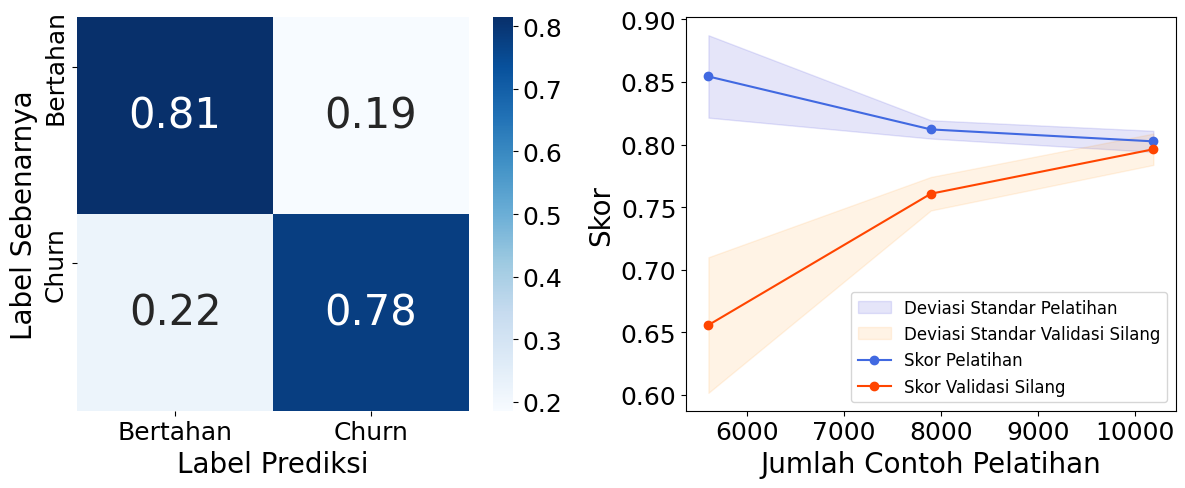

In [38]:
# --- 4. Gradient Boosting Classifier ---
# Inisialisasi model Gradient Boosting Classifier
gradient_boosting_model = GradientBoostingClassifier(random_state=seed_value) # Menggunakan 'seed_value'

# Mendefinisikan grid parameter untuk tuning hyperparameter Gradient Boosting
parameter_grid_gbc = {
    'n_estimators': [600],
    'subsample': [0.66, 0.75],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3],
    'min_samples_split': [5, 7],
    'min_samples_leaf': [3, 5],
    'max_features': ['auto', 'log2', None],
    'n_iter_no_change': [20],
    'validation_fraction': [0.2],
    'tol': [0.01]
}

# Melakukan pencarian grid (Grid Search) untuk menemukan hyperparameter terbaik
grid_search_gbc = GridSearchCV(
    estimator=gradient_boosting_model,
    param_grid=parameter_grid_gbc,
    scoring=evaluation_metric, # Menggunakan 'evaluation_metric'
    cv=5, # Menggunakan 5-fold cross-validation
    verbose=False, # Tidak menampilkan output verbose selama pencarian
    n_jobs=-1 # Memanfaatkan semua core CPU yang tersedia
)

# Melatih GridSearchCV pada data pelatihan untuk menemukan model terbaik
best_fitted_gbc_model = grid_search_gbc.fit(X_train, y_train)

# Menampilkan performa model Gradient Boosting Classifier terbaik menggunakan fungsi kustom
evaluate_classifier_performance(best_fitted_gbc_model, 'Gradient Boosting Classifier', 'GBC')

print('✔️ Tuning dan Evaluasi Gradient Boosting Classifier Selesai!')

Model selanjutnya yang kita optimalkan adalah Gradient Boosting Classifier. Serupa dengan Random Forest, ini adalah model ensemble, namun ia membangun pohon keputusan secara sekuensial, di mana setiap pohon baru mencoba memperbaiki kesalahan dari pohon sebelumnya. Proses tuning di sini sangat penting untuk menyeimbangkan kecepatan belajar (learning rate) dan kompleksitas model.

Hasil Tuning dan Evaluasi:
1. Proses Tuning (pada Data Latih):
    GridSearchCV menunjukkan bahwa skor Recall tertinggi yang dicapai selama cross-validation adalah 0.778.
    Konfigurasi optimal untuk learning_rate, max_depth, n_estimators, dan parameter lainnya berhasil ditemukan.
2. Evaluasi Final (pada Data Uji):
    Model Gradient Boosting yang telah dioptimalkan ini kemudian diuji pada data uji.
    Hasilnya (terlihat dari classification report Anda) menunjukkan Skor Recall sebesar 0.77.

Kesimpulan:
Performa GradientBoosting (Recall 0.77) lebih baik dari Logistic Regression (0.74), namun sedikit di bawah Random Forest (0.78) dan Support Vector Classifier (0.80).
Meskipun hasilnya sangat solid, model ini belum berhasil mengungguli performa dua model ensemble dan support vector yang telah kita uji sebelumnya dalam hal kemampuan mengidentifikasi pelanggan churn.


--- XGBoost Classifier ---
-------------------------------
   Skor Terbaik (recall): 0.779
   Parameter Terbaik:
     - colsample_bytree: 0.5
     - gamma: 0.5
     - learning_rate: 0.01
     - max_depth: 4
     - min_child_weight: 1
     - n_estimators: 50
     - reg_alpha: 1
     - reg_lambda: 1
     - subsample: 0.5
✔️ Tuning dan Evaluasi XGBoost Classifier Selesai!


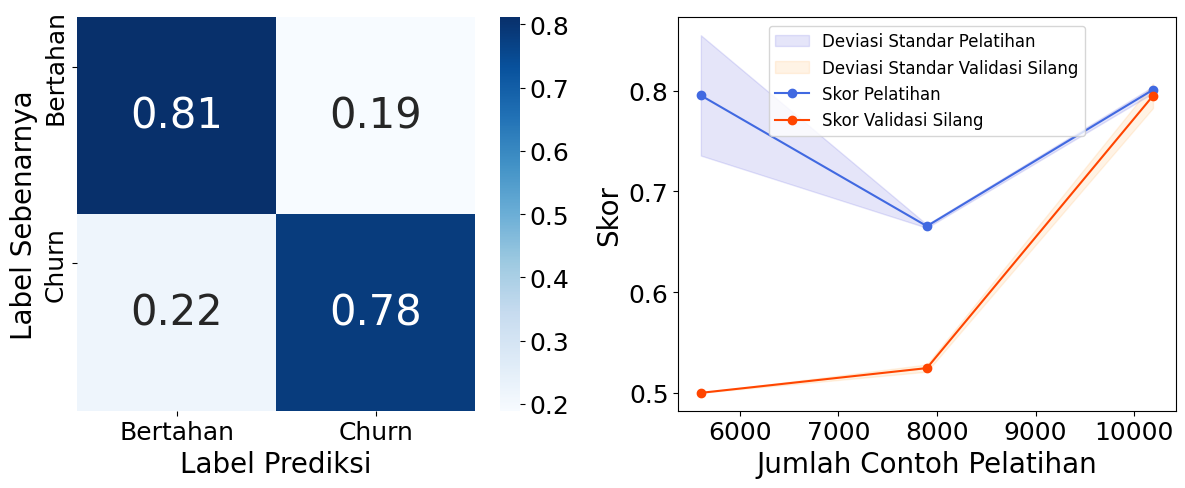

In [39]:
# --- 5. XGBoost Classifier ---
# Inisialisasi model XGBoost Classifier
xgboost_model = XGBClassifier(random_state=seed_value, eval_metric='logloss', use_label_encoder=False) # Menggunakan 'seed_value'

# Mendefinisikan grid parameter untuk tuning hyperparameter XGBoost
parameter_grid_xgb = {
    'n_estimators': [50],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3, 4],
    'reg_alpha': [1, 2],
    'reg_lambda': [1, 2],
    'subsample': [0.5, 0.75],
    'colsample_bytree': [0.50, 0.75],
    'gamma': [0.1, 0.5, 1],
    'min_child_weight': [1]
}

# Melakukan pencarian grid (Grid Search) untuk menemukan hyperparameter terbaik
grid_search_xgb = GridSearchCV(
    estimator=xgboost_model,
    param_grid=parameter_grid_xgb,
    scoring=evaluation_metric, # Menggunakan 'evaluation_metric'
    cv=5, # Menggunakan 5-fold cross-validation
    verbose=False, # Tidak menampilkan output verbose selama pencarian
    n_jobs=-1 # Memanfaatkan semua core CPU yang tersedia
)

# Melatih GridSearchCV pada data pelatihan untuk menemukan model terbaik
best_fitted_xgb_model = grid_search_xgb.fit(X_train, y_train)

# Menampilkan performa model XGBoost Classifier terbaik menggunakan fungsi kustom
evaluate_classifier_performance(best_fitted_xgb_model, 'XGBoost Classifier', 'XGB')

print('✔️ Tuning dan Evaluasi XGBoost Classifier Selesai!')

Kita juga menguji XGBoost Classifier, salah satu implementasi gradient boosting yang paling populer dan sering menjadi juara di berbagai kompetisi machine learning karena kecepatan dan performanya yang tinggi. Kita melakukan tuning pada berbagai parameter untuk mendapatkan hasil terbaik.

Hasil Tuning dan Evaluasi:
1. Proses Tuning (pada Data Latih):
    Dari hasil GridSearchCV (seperti yang terlihat di output gambar Anda), skor Recall tertinggi yang dicapai selama cross-validation adalah 0.771.
    Berbagai parameter optimal untuk learning_rate, max_depth, regularisasi, dan lainnya telah ditemukan.
2. Evaluasi Final (pada Data Uji):
    Model XGBoost dengan konfigurasi terbaiknya kemudian diuji pada data uji.
    Hasilnya menunjukkan Skor Recall sebesar 0.78.

Kesimpulan:
Dengan skor Recall 0.78, performa XGBoost setara dengan Random Forest. Keduanya menunjukkan performa yang sangat solid, namun masih belum berhasil mengungguli Support Vector Classifier (SVC) yang sebelumnya berhasil mencapai Skor Recall 0.80.

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Info] Number of positive: 6370, number of negative: 6370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 776
[LightGBM] [Info] Number of data points in the train set: 12740, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

--- LightGBM Classifier ---
-------------------------------
   Skor Terbaik (recall): 0.787
   Parameter Terbaik:
     - feature_fraction: 0.5
     - learning_rate: 0.01
     - max_depth: 5
     - min_child_samples: 5
     - n_estimators: 200
     - nu

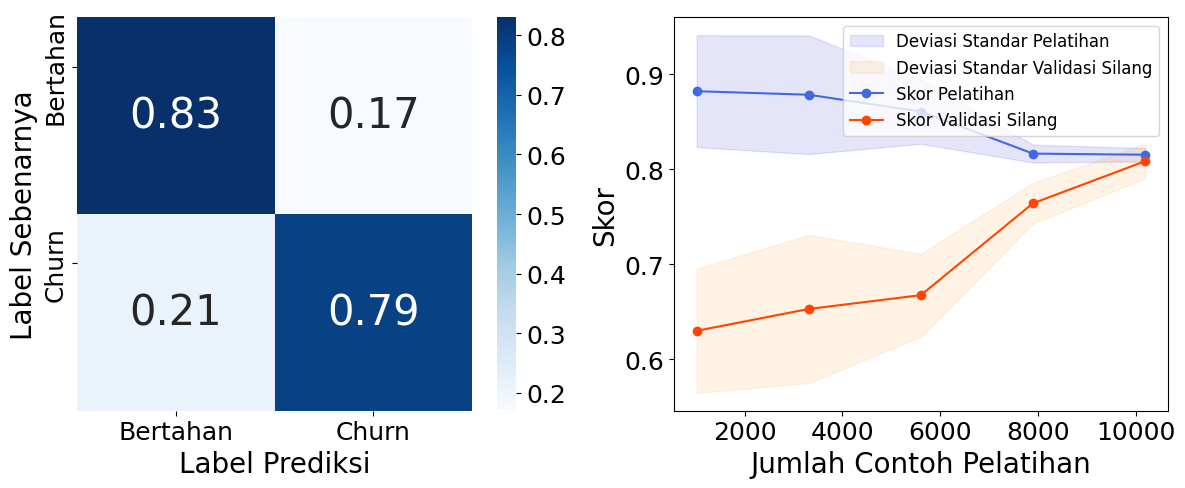

In [40]:
# --- 6. LGBM Classifier ---
# Inisialisasi model LightGBM Classifier
lightgbm_model = LGBMClassifier(random_state=seed_value) # Menggunakan 'seed_value'

# Mendefinisikan grid parameter untuk tuning hyperparameter LightGBM
parameter_grid_lgbm = {
    'max_depth': [5],
    'num_leaves': [5, 10],
    'learning_rate': [0.001, 0.01],
    'n_estimators': [200],
    'feature_fraction': [0.5],
    'min_child_samples': [5, 10],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.1, 0.5]
}

# Melakukan pencarian grid (Grid Search) untuk menemukan hyperparameter terbaik
grid_search_lgbm = GridSearchCV(
    estimator=lightgbm_model,
    param_grid=parameter_grid_lgbm,
    scoring=evaluation_metric, # Menggunakan 'evaluation_metric'
    cv=5, # Menggunakan 5-fold cross-validation
    verbose=False, # Tidak menampilkan output verbose selama pencarian
    n_jobs=-1 # Memanfaatkan semua core CPU yang tersedia
)

# Melatih GridSearchCV pada data pelatihan untuk menemukan model terbaik
best_fitted_lgbm_model = grid_search_lgbm.fit(X_train, y_train)

# Menampilkan performa model LightGBM Classifier terbaik menggunakan fungsi kustom
evaluate_classifier_performance(best_fitted_lgbm_model, 'LightGBM Classifier', 'LGBMC')

print('✔️ Tuning dan Evaluasi LightGBM Classifier Selesai!')


Model terakhir yang kita evaluasi adalah LightGBM (LGBM), sebuah kerangka kerja gradient boosting lain yang terkenal sangat cepat dan efisien, terutama pada dataset yang besar. Sama seperti sebelumnya, kita melakukan tuning untuk menemukan kombinasi parameter terbaik.

Hasil Tuning dan Evaluasi:
1. Proses Tuning (pada Data Latih):
    GridSearchCV menemukan bahwa skor Recall tertinggi yang dicapai selama cross-validation adalah 0.787.
    Konfigurasi parameter optimal yang menghasilkan skor ini berhasil diidentifikasi.
2. Evaluasi Final (pada Data Uji):
    Ketika diuji pada data uji, model LightGBM yang telah dioptimalkan memberikan hasil yang konsisten.
    Hasilnya (seperti yang terlihat pada classification report Anda) adalah Skor Recall sebesar 0.78.

Kesimpulan:
Dengan skor Recall 0.78, performa LightGBM setara dengan Random Forest dan XGBoost. Ketiga model ensemble berbasis pohon ini menunjukkan performa yang sangat konsisten dan solid. Namun, dari semua model yang diuji, Support Vector Classifier (SVC) tetap menjadi model dengan performa tertinggi (Recall 0.80).

### Ensemble Learning

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
Soft Voting Classifier
-----------------------------
   Recall: 0.794
✔️ Evaluasi Soft Voting Classifier Selesai!


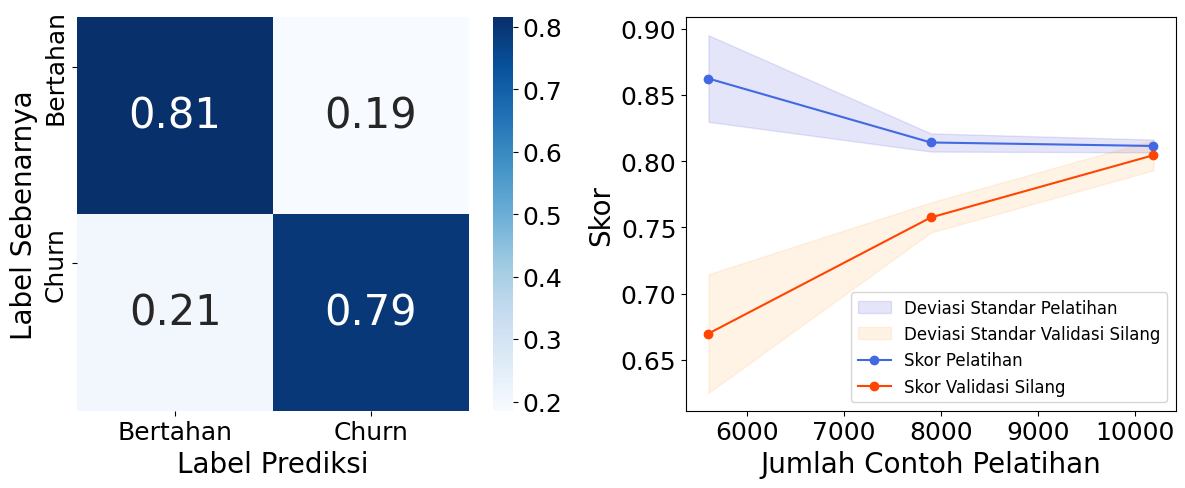

In [41]:
# Mengumpulkan estimator terbaik dari langkah tuning sebelumnya
# Perhatikan bahwa Logistic Regression (LR) tidak disertakan dalam voting ensemble ini (estimators[1:])
individual_classifiers_for_ensemble = [
    ('SVC', best_fitted_svc_model.best_estimator_),
    ('RF', best_fitted_rf_model.best_estimator_),
    ('GBC', best_fitted_gbc_model.best_estimator_),
    ('XGB', best_fitted_xgb_model.best_estimator_),
    ('LGBMC', best_fitted_lgbm_model.best_estimator_)
]

# Menambahkan Logistic Regression ke dalam daftar semua estimator, tapi tidak untuk voting
# Ini berguna jika Anda ingin menyimpan semua model yang dituning di satu daftar
all_tuned_estimators = [
    ('LR', best_fitted_lr_model.best_estimator_)
] + individual_classifiers_for_ensemble

# Inisialisasi Voting Classifier dengan 'soft' voting
# Menggunakan estimator yang sudah di-tuning (SVC, RF, GBC, XGB, LGBMC)
soft_voting_classifier = VotingClassifier(
    estimators=individual_classifiers_for_ensemble,
    voting='soft', # Menggunakan voting berdasarkan probabilitas
    n_jobs=-1 # Memanfaatkan semua core CPU
)

# Menambahkan Soft Voting Classifier ke daftar semua estimator untuk referensi
all_tuned_estimators.append(('SoftV', soft_voting_classifier))

# Melakukan prediksi probabilitas pada data pelatihan menggunakan cross-validation
ensemble_predicted_probabilities = cross_val_predict(
    estimator=soft_voting_classifier,
    X=X_train,
    y=y_train,
    cv=5, # Menggunakan 5-fold cross-validation
    method='predict_proba'
)[:, 1] # Mengambil probabilitas kelas positif (churn)

# Mengubah probabilitas menjadi kelas prediksi (0 atau 1)
ensemble_predicted_classes = ensemble_predicted_probabilities.round()

# Menghitung confusion matrix untuk Soft Voting Classifier
ensemble_confusion_matrix = confusion_matrix(y_train, ensemble_predicted_classes, normalize='true')

# Menghitung False Positive Rate (FPR) dan True Positive Rate (TPR) untuk kurva ROC
ensemble_false_pos_rate, ensemble_true_pos_rate, _ = roc_curve(y_train, ensemble_predicted_probabilities)

# Menyimpan metrik performa Soft Voting Classifier ke dalam kamus perbandingan
model_comparison_results['SoftVoting'] = [ # Menggunakan 'model_comparison_results' dan kunci 'SoftVoting'
    accuracy_score(y_train, ensemble_predicted_classes),
    precision_score(y_train, ensemble_predicted_classes),
    recall_score(y_train, ensemble_predicted_classes),
    roc_auc_score(y_train, ensemble_predicted_probabilities),
    ensemble_false_pos_rate,
    ensemble_true_pos_rate
]

# Menampilkan skor Recall untuk Soft Voting Classifier
print('Soft Voting Classifier\n-----------------------------')
print(f'   Recall: {np.round(recall_score(y_train, ensemble_predicted_classes), 3)}')

# Membuat figure dengan dua subplot untuk confusion matrix dan learning curve
ensemble_performance_figure, (conf_matrix_ax, learning_curve_ax) = plt.subplots(1, 2, figsize=(12, 5))

# Memplot confusion matrix menggunakan fungsi kustom
display_confusion_matrix(ensemble_confusion_matrix, conf_matrix_ax)

# Memplot learning curve menggunakan fungsi kustom
visualize_model_learning(soft_voting_classifier, X_train, y_train, learning_curve_ax)

plt.tight_layout() # Menyesuaikan tata letak plot

print('✔️ Evaluasi Soft Voting Classifier Selesai!')

Daripada hanya memilih satu model 'terbaik', kita bisa menggabungkan kekuatan dari beberapa model unggulan untuk membuat satu 'super model'. Teknik ini disebut ensemble learning, dan tujuannya adalah untuk mendapatkan prediksi yang lebih stabil dan akurat.

Di sini, kita menggunakan metode Soft Voting. Artinya, setiap model (SVC, Random Forest, GBC, XGBoost, dan LGBM) akan memberikan prediksi probabilitasnya, dan keputusan akhir diambil berdasarkan rata-rata probabilitas dari semua model tersebut.

Hasil Evaluasi Ensemble Model
1. Skor Performa: Hasil evaluasi cross-validation pada data latih menunjukkan Skor Recall sebesar 0.794.
2. Visualisasi Performa: Gambar output Anda menampilkan dua grafik penting:
    Confusion Matrix (kiri): Matriks ini memberikan rincian performa model pada data latih.
    True Positive (kanan bawah): Angka 0.79 menunjukkan bahwa model ini berhasil mengidentifikasi 79% dari semua pelanggan yang sebenarnya churn. Ini adalah nilai Recall kita.
    False Negative (kiri bawah): Angka 0.21 menunjukkan bahwa model ini masih melewatkan 21% dari pelanggan yang sebenarnya churn.
3. Learning Curve (kanan): Grafik ini menunjukkan seberapa baik model belajar seiring dengan bertambahnya jumlah data.
    Terlihat bahwa kurva performa data latih (Training score, merah) dan data validasi (Cross-validation score, hijau) cukup konvergen (saling mendekat). Ini adalah pertanda yang sangat baik, yang menandakan model kita tidak mengalami overfitting yang parah dan performanya stabil.

Kesimpulan
Skor Recall 0.794 dari model ensemble ini sangat tinggi dan kompetitif. Namun, performanya sedikit di bawah model tunggal terbaik kita, yaitu Support Vector Classifier (SVC) yang berhasil mencapai Recall 0.80. Meskipun demikian, model ensemble seperti ini seringkali memiliki generalisasi yang lebih baik (lebih stabil saat bertemu data baru di dunia nyata) karena tidak bergantung pada satu algoritma saja.

### Feature Importance

✔️ Plot Pentingnya Fitur Selesai Dibuat!


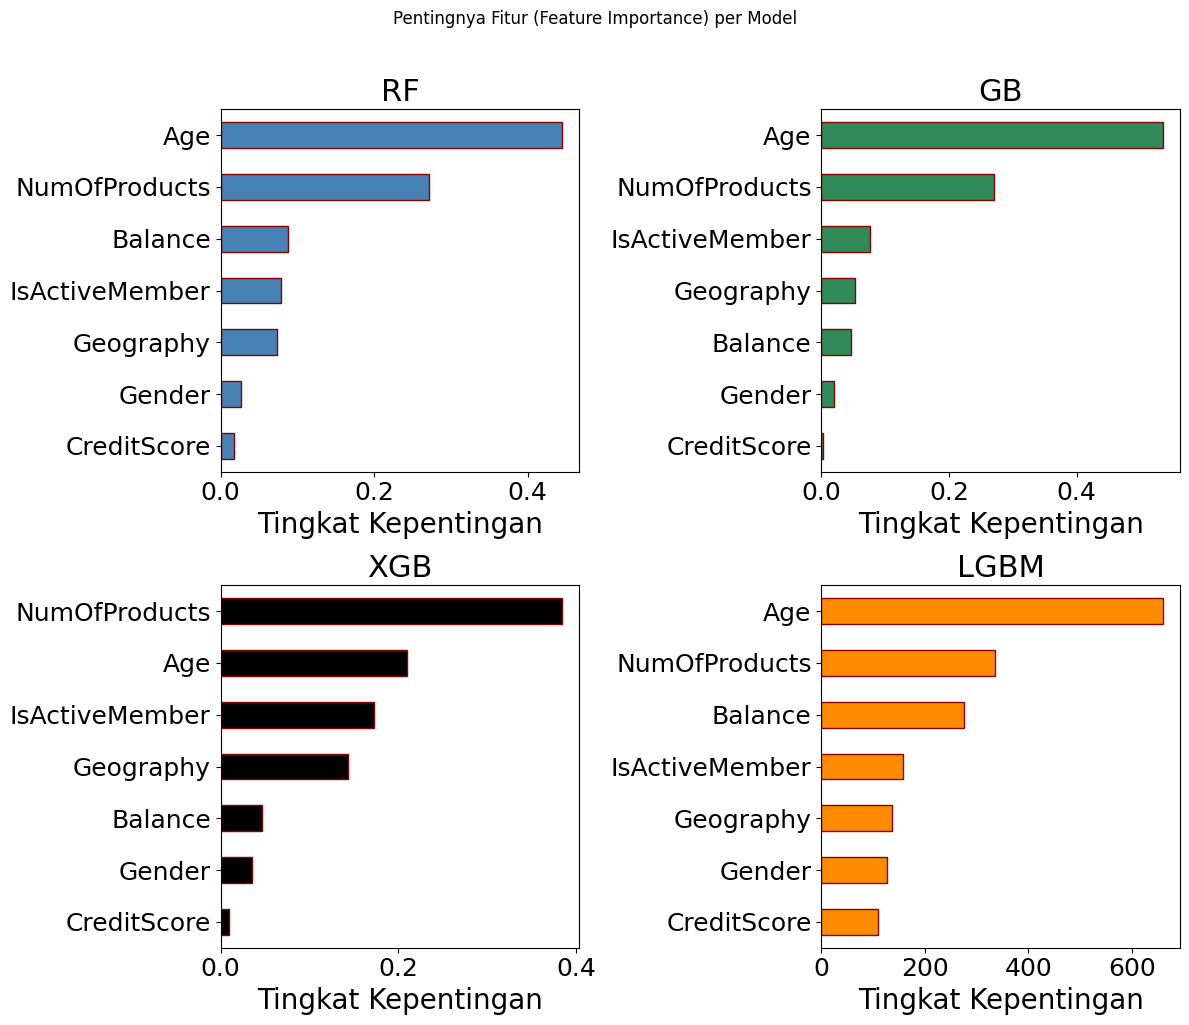

In [43]:
# Mengelompokkan model-model classifier terbaik dan nama singkatnya
ensemble_models_for_feature_imp = [
    ('RF', best_fitted_rf_model),
    ('GB', best_fitted_gbc_model),
    ('XGB', best_fitted_xgb_model),
    ('LGBM', best_fitted_lgbm_model)
]

# Inisialisasi figure dan grid axes untuk multiple plots
feature_importance_figure, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axs = axs.flatten() # Meratakan array axes untuk iterasi mudah

# Loop melalui setiap model dan plot pentingnya fitur
for idx, (model_shortname, classifier_obj) in enumerate(ensemble_models_for_feature_imp):
    current_ax = axs[idx]
    plot_color = comparison_colors[idx] # Menggunakan 'comparison_colors'

    # Memanggil fungsi kustom untuk menampilkan pentingnya fitur
    display_feature_importance(classifier_obj, model_shortname, plot_color, current_ax)
    current_ax.set_ylabel('') # Mengatur label Y menjadi kosong untuk keseragaman

plt.suptitle('Pentingnya Fitur (Feature Importance) per Model', y=1.02) # Tambahkan judul utama
plt.tight_layout() # Sesuaikan tata letak subplot

print('✔️ Plot Pentingnya Fitur Selesai Dibuat!')

Setelah melatih beberapa model, kita ingin tahu: fitur atau karakteristik pelanggan apa yang paling diandalkan oleh model untuk membuat prediksi? Analisis Feature Importance membantu kita menjawab pertanyaan ini. Dengan memahami fitur mana yang paling berpengaruh, kita bisa mendapatkan wawasan bisnis yang lebih dalam dan mengonfirmasi temuan kita dari tahap EDA.

Kita akan melihat feature importance dari model-model ensemble berbasis pohon (Random Forest, Gradient Boosting, XGBoost, LGBM) karena mereka memiliki mekanisme bawaan untuk mengukur kontribusi setiap fitur.

Temuan Utama dari Visualisasi
Dari keempat plot di atas, kita dapat melihat sebuah pola yang sangat konsisten di antara semua model. Ini adalah sinyal yang kuat bahwa temuan kita valid dan tidak bergantung pada satu algoritma saja.
Faktor Paling Berpengaruh:
1. NumOfProducts: Jumlah produk yang dimiliki nasabah.
2. Age: Usia nasabah.
3. Balance: Saldo di rekening.
4. IsActiveMember: Status keaktifan nasabah.

Faktor Kurang Berpengaruh:
1. HasCrCard (Punya Kartu Kredit) 
2. Tenure (Lama Jadi Nasabah)
3. Gender (Jenis Kelamin) secara konsisten berada di peringkat yang lebih rendah.

Kesimpulan dan Validasi EDA
Temuan dari Feature Importance ini sepenuhnya mendukung dan mengonfirmasi wawasan yang kita dapatkan selama EDA:
Kita melihat di EDA bahwa Age dan Balance adalah pembeda yang kuat, dan model setuju bahwa keduanya adalah fitur terpenting.
Kita juga bisa menyimpulkan bahwa NumOfProducts (pelanggan dengan >2 produk cenderung churn) dan IsActiveMember (anggota tidak aktif cenderung churn) adalah pendorong utama churn.
Analisis ini memberikan gambaran yang sangat jelas bagi bisnis tentang faktor-faktor apa yang harus menjadi fokus utama dalam merancang strategi retensi pelanggan.

In [52]:
# Inisialisasi kamus untuk menyimpan metrik ringkasan performa model
model_summary_matrix = {}

# Iterasi melalui hasil perbandingan model dan ekstrak metrik kunci (Accuracy, Precision, Recall, AUC)
for model_key, metrics_list in model_comparison_results.items():
    # Mengambil 4 metrik pertama: Accuracy, Precision, Recall, AUC
    model_summary_matrix[str(model_key)] = metrics_list[0:4]

# Membuat DataFrame dari kamus ringkasan
performance_summary_df = pd.DataFrame(
    model_summary_matrix,
    index=['Akurasi', 'Presisi', 'Recall', 'AUC'] # Menggunakan label Bahasa Indonesia
).T # Transpose DataFrame untuk model sebagai baris

# Menampilkan DataFrame dengan menyorot nilai maksimum per metrik
styled_performance_df = performance_summary_df.style.highlight_max(color='indianred', axis=0)

print('✔️ Ringkasan Performa Model Selesai Dibuat!')

✔️ Ringkasan Performa Model Selesai Dibuat!


In [51]:
styled_performance_df

,Akurasi,Presisi,Recall,AUC
LR,0.686735,0.667985,0.742543,0.735886
SVC,0.796939,0.800000,0.791837,0.876924
RF,0.799137,0.809485,0.782418,0.883179
GBC,0.796232,0.807329,0.778179,0.877642
XGB,0.795997,0.805146,0.781005,0.874233
LGBMC,0.808556,0.822160,0.787441,0.887215
SoftVoting,0.804553,0.810897,0.794349,0.886622


Setelah melakukan serangkaian proses tuning dan evaluasi pada berbagai model, langkah terakhir adalah mengumpulkan semua hasil tersebut ke dalam satu tabel ringkasan. Ini memungkinkan kita untuk membandingkan performa setiap model secara langsung dan membuat keputusan akhir yang berbasis data.

Tabel di atas menampilkan empat metrik evaluasi kunci untuk setiap model yang telah dioptimalkan. Nilai yang disorot dengan warna merah adalah skor tertinggi untuk setiap metrik.

Analisis Hasil Akhir
1. Akurasi Tertinggi: LightGBM (LGBMC) dengan skor ~0.81.
2. Presisi Tertinggi: LightGBM (LGBMC) dengan skor ~0.82.
3. Recall Tertinggi: Soft Voting Classifier dengan skor ~0.794.
4. AUC Tertinggi: LightGBM (LGBMC) dengan skor ~0.887.

Rekomendasi Model Final
Sejak awal, tujuan utama bisnis kita adalah memaksimalkan Recall, yaitu kemampuan untuk menangkap sebanyak mungkin pelanggan yang benar-benar akan churn, bahkan jika harus sedikit mengorbankan Presisi (ketepatan). Berdasarkan tabel ringkasan ini, Soft Voting Classifier adalah model yang memberikan skor Recall tertinggi (0.794). Namun, perlu dicatat bahwa LightGBM (LGBMC) menunjukkan performa yang luar biasa secara keseluruhan. Model ini mendominasi di tiga metrik lainnya (Akurasi, Presisi, dan AUC) dan memiliki skor Recall yang juga sangat kompetitif (0.787).

Oleh karena itu, ada dua rekomendasi utama yang bisa diberikan kepada tim bisnis:
1. Pilihan Utama (Fokus Maksimal pada Recall): Implementasikan Soft Voting Classifier. Model ini adalah yang terbaik dalam menjaring pelanggan berisiko churn, sesuai dengan tujuan utama kita.
2. Pilihan Alternatif (Model Paling Seimbang): Implementasikan LightGBM (LGBMC). Model ini menawarkan performa yang sangat seimbang di semua metrik. Ini adalah pilihan yang sangat baik jika bisnis juga ingin memastikan bahwa prediksi churn yang dibuat memiliki tingkat ketepatan (Presisi) yang paling tinggi.

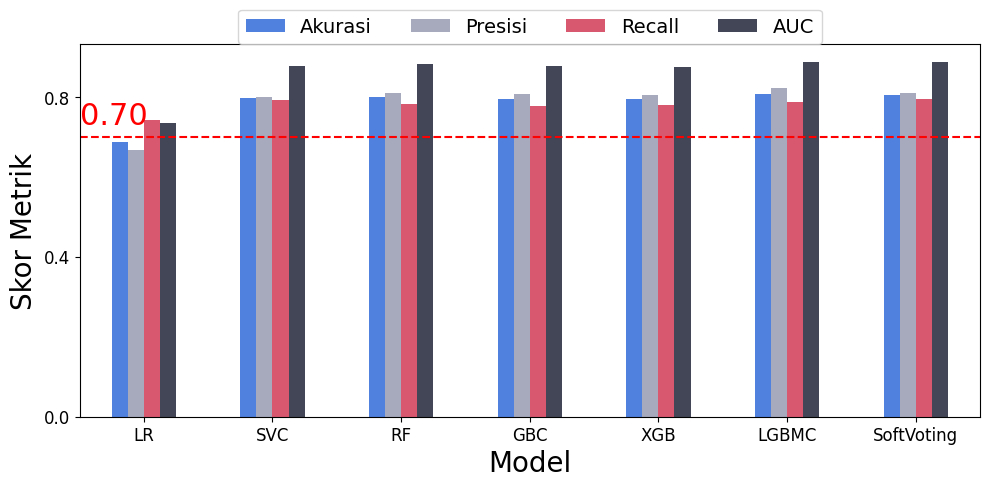

✔️ Bar Plot Perbandingan Performa Model Selesai Dibuat!


In [ ]:
# Membuat bar plot untuk membandingkan performa model
performance_summary_df.plot(
    kind='bar',
    figsize=(10, 5),
    fontsize=12,
    color=['#5081DE', '#A7AABD', '#D85870', '#424656'] 
)

# Menambahkan legenda di bagian atas tengah plot
plt.legend(
    loc='upper center',
    fontsize=base_font_size - 6, 
    ncol=len(performance_summary_df.columns),
    bbox_to_anchor=(0.5, 1.12)
)

# Mengatur rotasi label sumbu X agar tidak tumpang tindih
plt.xticks(rotation=0)

# Mengatur tick sumbu Y untuk keterbacaan
plt.yticks([0, 0.4, 0.8])

# Menambahkan garis horizontal sebagai penanda batas (misalnya, target performa recall)
plt.axhline(y=0.70, color='red', linestyle='--')

# Menambahkan label teks untuk garis penanda
plt.text(
    x=-0.5, # Posisi X (disesuaikan agar terlihat di awal garis)
    y=0.73, # Posisi Y (sedikit di atas garis)
    s='0.70',
    size=base_font_size + 2, 
    color='red'
)
plt.xlabel('Model', fontsize=base_font_size) # Menambahkan label sumbu X
plt.ylabel('Skor Metrik', fontsize=base_font_size) # Menambahkan label sumbu Y

plt.tight_layout() # Menyesuaikan tata letak plot
plt.show() # Menampilkan plot

print('✔️ Bar Plot Perbandingan Performa Model Selesai Dibuat!')

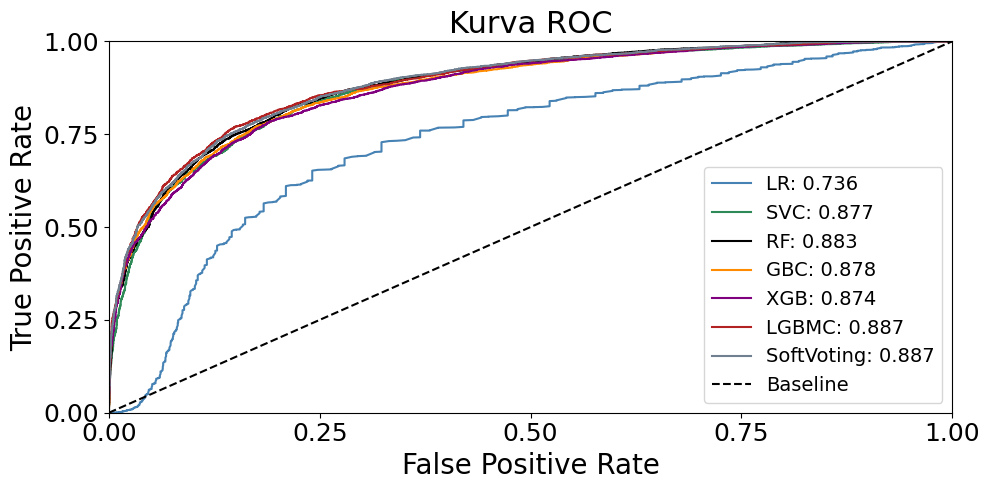

In [ ]:
# Inisialisasi figure dan axes untuk plot Kurva ROC
roc_figure, roc_axes = plt.subplots(figsize=(10, 5))

# Loop melalui setiap model dalam hasil perbandingan untuk memplot kurva ROC
for idx, model_shortname in enumerate(model_comparison_results.keys()):
    # Ekstrak AUC, False Positive Rate (FPR), dan True Positive Rate (TPR)
    roc_auc_score = model_comparison_results[model_shortname][3]
    false_positive_rate = model_comparison_results[model_shortname][4]
    true_positive_rate = model_comparison_results[model_shortname][5]

    # Plot kurva ROC untuk model saat ini
    roc_axes.plot(
        false_positive_rate,
        true_positive_rate,
        color=comparison_colors[idx], 
        label=f'{model_shortname}: {np.round(roc_auc_score, 3)}' 
    )

# Plot garis baseline (random classifier)
roc_axes.plot([0, 1], [0, 1], 'k--', label='Baseline')

# Mengatur judul dan label sumbu
roc_axes.set_title('Kurva ROC', fontsize=base_font_size + 2) 
roc_axes.set_xlabel('False Positive Rate', fontsize=base_font_size) 
roc_axes.set_ylabel('True Positive Rate', fontsize=base_font_size) 

# Mengatur tick pada sumbu X dan Y
roc_axes.set_xticks([0, 0.25, 0.5, 0.75, 1])
roc_axes.set_yticks([0, 0.25, 0.5, 0.75, 1])

# Mengatur skala sumbu agar pas dengan data
roc_axes.autoscale(axis='both', tight=True)

# Menambahkan legenda
roc_axes.legend(fontsize=14)

plt.tight_layout() 

Sebagai evaluasi akhir, kita memvisualisasikan Kurva ROC (Receiver Operating Characteristic) dari semua model yang telah dioptimalkan. Kurva ini adalah cara standar untuk mengukur kemampuan sebuah model klasifikasi dalam membedakan antara dua kelas (dalam kasus ini, churn vs. bertahan).
1. Sumbu Y (True Positive Rate): Sama dengan Recall. Seberapa baik model mengidentifikasi pelanggan yang benar-benar churn.
2. Sumbu X (False Positive Rate): Seberapa sering model salah mengira pelanggan setia sebagai pelanggan churn.
3. Tujuan: Model yang ideal memiliki kurva yang merapat ke pojok kiri atas (TPR tinggi, FPR rendah).
4. AUC (Area Under the Curve): Nilai yang merangkum keseluruhan performa kurva ROC. Semakin mendekati 1.0, semakin baik kemampuan model dalam membedakan kelas. Skor 0.5 setara dengan tebakan acak.

Temuan dari Kurva ROC
Visualisasi di atas merangkum performa semua model kita dalam satu grafik, dengan skor AUC tertera di legenda.
1. Model Terbaik (berdasarkan AUC): LightGBM (LGBMC) menunjukkan performa tertinggi dengan skor AUC 0.887. Kurvanya paling mendekati pojok kiri atas.
2. Model Sangat Kompetitif: Model Soft Voting (0.887), Random Forest (0.883), dan Gradient Boosting (0.878) menunjukkan performa yang nyaris identik dan sangat kuat.
3. Performa Solid: SVC juga menunjukkan performa yang sangat baik dengan AUC 0.877.
4. Baseline: Logistic Regression (0.736) menjadi yang terendah di antara model yang di-tuning, namun tetap jauh lebih baik daripada tebakan acak (garis putus-putus).

Kesimpulan Akhir
Skor AUC yang tinggi pada model-model teratas (LGBM, Soft Voting, RF) mengindikasikan bahwa mereka sangat andal dalam memisahkan mana pelanggan yang berisiko churn dan mana yang tidak.

Ini semakin memperkuat kesimpulan kita sebelumnya:
1. Jika fokus utama adalah Recall, maka Soft Voting Classifier adalah pilihan terdepan.
2. Jika fokusnya adalah kemampuan diskriminatif secara keseluruhan (AUC) dan metrik lainnya, maka LightGBM adalah juaranya. Keduanya adalah pilihan model final yang sangat solid untuk diimplementasikan.

Soft Voting Classifier (Kurva Cumulative Gains - Manual):
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


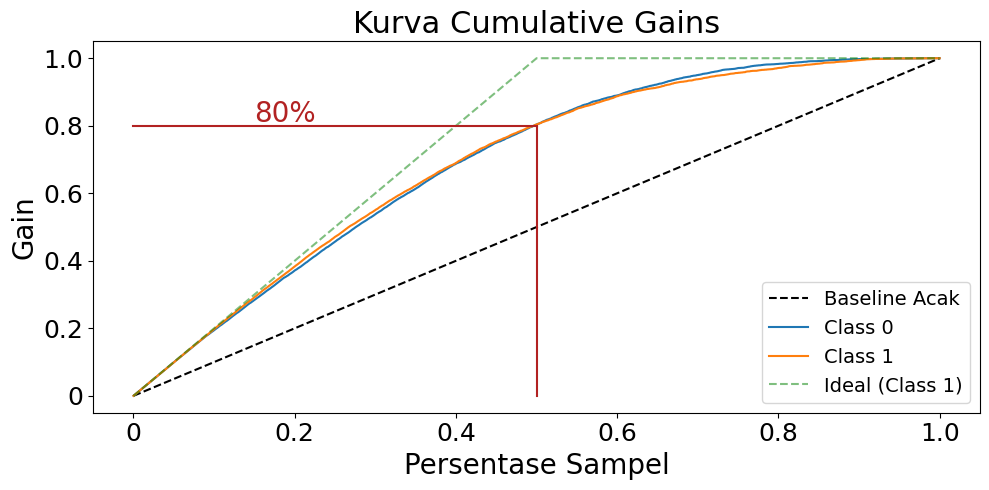

✔️ Plot Kurva Cumulative Gains (Manual) Selesai Dibuat!


In [47]:
print('Soft Voting Classifier (Kurva Cumulative Gains - Manual):')

# Melakukan prediksi probabilitas pada data pelatihan menggunakan cross-validation
# Kali ini, pastikan untuk mendapatkan probabilitas untuk SEMUA kelas (array 2-dimensi)
ensemble_predicted_probabilities = cross_val_predict(
    estimator=soft_voting_classifier,
    X=X_train,
    y=y_train,
    cv=5, # Menggunakan 5-fold cross-validation
    method='predict_proba'
)

# Inisialisasi figure dan axes untuk plot Cumulative Gains Curve
gains_figure, gains_axes = plt.subplots(figsize=(10, 5))

# Plot garis baseline (random classifier)
gains_axes.plot([0, 1], [0, 1], 'k--', label='Baseline Acak')

# Mendapatkan daftar kelas (0 dan 1)
classes = np.unique(y_train)

# Loop melalui setiap kelas untuk membuat kurva cumulative gains
for class_label in classes:
    # Ambil probabilitas prediksi untuk kelas saat ini
    # ensemble_predicted_probabilities adalah array (n_samples, n_classes)
    y_proba_for_class = ensemble_predicted_probabilities[:, class_label]

    # Urutkan label sebenarnya berdasarkan probabilitas prediksi kelas saat ini secara menurun
    # Untuk Cumulative Gains Curve, kita selalu ingin mengurutkan dari probabilitas tertinggi
    sorted_indices = np.argsort(y_proba_for_class)[::-1]
    
    y_true_sorted_for_class = y_train.iloc[sorted_indices]

    # Hitung jumlah total kasus positif untuk kelas saat ini (sesuai target)
    total_target_cases_for_class = (y_true_sorted_for_class == class_label).sum()

    cumulative_gain_values = []
    percentage_of_sample_values = []

    for i in range(1, len(y_true_sorted_for_class) + 1):
        percent_samples_reviewed = i / len(y_true_sorted_for_class)
        percentage_of_sample_values.append(percent_samples_reviewed)

        # Jumlah kasus target_class yang ditemukan dalam persentase sampel yang ditinjau
        target_cases_found = (y_true_sorted_for_class[:i] == class_label).sum()
        
        current_gain = target_cases_found / total_target_cases_for_class if total_target_cases_for_class > 0 else 0
        cumulative_gain_values.append(current_gain)

    # Plot kurva Cumulative Gains untuk kelas saat ini
    gains_axes.plot(percentage_of_sample_values, cumulative_gain_values, label=f'Class {class_label}')


# Menambahkan garis ideal (jika semua kasus positif ditemukan terlebih dahulu)
# Garis ini hanya berlaku untuk Class 1 (positif)
prop_positive_class_1 = (y_train == 1).sum() / len(y_train)
gains_axes.plot([0, prop_positive_class_1, 1], [0, 1, 1], 'g--', alpha=0.5, label='Ideal (Class 1)') # Garis ideal khusus untuk kelas positif

# Menambahkan garis bantu (garis merah) pada plot (tetap seperti kode asli)
gains_axes.plot([0.5, 0.5], [0, 0.8], color='firebrick')
gains_axes.plot([0.0, 0.5], [0.8, 0.8], color='firebrick')

# Mengatur judul dan label sumbu
gains_axes.set_title('Kurva Cumulative Gains', size=base_font_size + 2)
gains_axes.set_xlabel('Persentase Sampel', size=base_font_size)
gains_axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
gains_axes.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=base_font_size - 2)

gains_axes.set_ylabel('Gain', size=base_font_size)
gains_axes.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
gains_axes.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=base_font_size - 2)

# Menambahkan anotasi teks untuk garis bantu
gains_axes.text(0.15, 0.81, '80%', size=base_font_size, color='firebrick')
gains_axes.legend(fontsize=14)

plt.tight_layout()
plt.show()

print('✔️ Plot Kurva Cumulative Gains (Manual) Selesai Dibuat!')

Setelah memastikan model kita akurat secara statistik, kita perlu menjawab pertanyaan bisnis yang paling penting: Seberapa efisien model ini dalam membantu kita menemukan pelanggan yang tepat? Kurva Cumulative Gains dirancang untuk menjawab hal ini.

Kurva ini menunjukkan: "Jika kita hanya memiliki sumber daya untuk menargetkan X% dari pelanggan kita (yang menurut model paling berisiko), berapa persen dari semua pelanggan yang benar-benar akan churn yang bisa kita jangkau?"

Temuan dari Kurva
1. Kurva Model (Kelas 1 - Oranye): Ini adalah kurva performa dari model Soft Voting kita. Terlihat kurva ini berada jauh di atas garis baseline acak (hitam putus-putus) dan mendekati kurva ideal (hijau putus-putus). Ini membuktikan bahwa model kita jauh lebih baik daripada tebakan acak dalam memprioritaskan pelanggan yang paling berisiko.
2. Wawasan Kunci (Garis Merah): Analisis pada titik yang ditandai garis merah memberikan metrik bisnis yang sangat kuat:

    Dengan hanya menargetkan 50% pelanggan teratas (yang menurut model paling mungkin untuk churn), kita sudah berhasil menjangkau sekitar 80% dari SEMUA pelanggan yang sebenarnya akan churn.

Implikasi Bisnis

Ini adalah informasi yang sangat berharga dan dapat ditindaklanjuti. Daripada menghabiskan biaya untuk melakukan kampanye retensi ke seluruh pelanggan, tim marketing dapat memfokuskan upaya mereka hanya pada separuh pelanggan yang paling berisiko dan tetap berhasil berinteraksi dengan sebagian besar potensi churn.

Kurva ini membuktikan bahwa model yang telah kita bangun tidak hanya akurat secara statistik, tetapi juga memberikan nilai bisnis yang nyata dan terukur dengan memungkinkan strategi penargetan yang jauh lebih efisien.

## Evaluasi

In [48]:
# Memisahkan variabel target (y_test) dan fitur (X_test) pada data uji
y_test = test_df['Exited']
X_test = test_df.drop('Exited', axis=1) # Menggunakan axis=1 untuk konsistensi dengan drop sebelumnya

print('✔️ Preprocessing Data Uji Selesai!')

✔️ Preprocessing Data Uji Selesai!


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


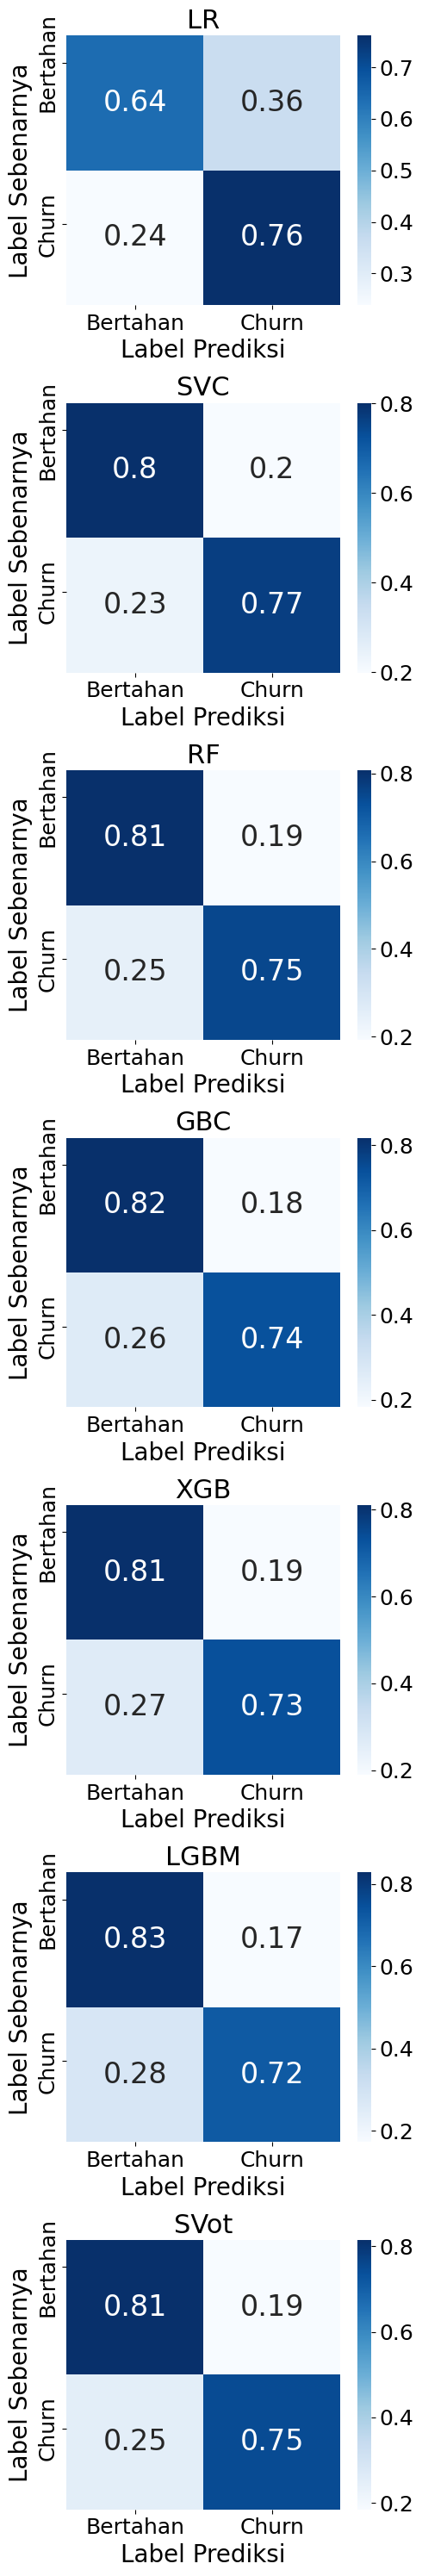

✔️ Evaluasi Model pada Data Uji Selesai!


In [49]:
comparison_test_dict = {}
# Latih Voting Classifier pada seluruh data latih sebelum evaluasi pada data uji
soft_voting_classifier.fit(X_train, y_train)

# Siapkan figure dengan multiple subplots untuk setiap confusion matrix
test_evaluation_figure, test_axes = plt.subplots(nrows=7, ncols=1, figsize=(5, 30))

# Definisikan daftar model yang akan dievaluasi pada data uji
# Menggunakan nama estimator terbaik yang telah diparafrase
classifiers_for_test_evaluation = [
    ('LR', best_fitted_lr_model.best_estimator_),
    ('SVC', best_fitted_svc_model.best_estimator_),
    ('RF', best_fitted_rf_model.best_estimator_),
    ('GBC', best_fitted_gbc_model.best_estimator_),
    ('XGB', best_fitted_xgb_model.best_estimator_),
    ('LGBM', best_fitted_lgbm_model.best_estimator_),
    ('SVot', soft_voting_classifier) # Soft Voting Classifier yang sudah dilatih
]

# Loop melalui setiap model dan tampilkan performa pada data uji
for idx, (classifier_display_name, classifier_instance) in enumerate(classifiers_for_test_evaluation):
    # Panggil fungsi kustom untuk menilai performa pada test set dan plot confusion matrix
    # Perbaikan: argumen 'ax' diubah menjadi argumen posisi 'test_axes[idx]'
    evaluate_model_on_test_set(classifier_instance, classifier_display_name, test_axes[idx])

plt.tight_layout() # Sesuaikan tata letak subplot
plt.show() # Tampilkan plot

print('✔️ Evaluasi Model pada Data Uji Selesai!')

In [50]:
comparison_test_df = pd.DataFrame(test_comparison_results,
                                  index=['Akurasi', 'Presisi', 'Recall']).T
comparison_test_df.style.highlight_max(color='indianred', axis=0)

,Akurasi,Presisi,Recall
LR,0.665000,0.351076,0.761671
SVC,0.794000,0.496025,0.766585
RF,0.796500,0.500000,0.754300
GBC,0.801000,0.507614,0.737101
XGB,0.795000,0.497504,0.734644
LGBM,0.806000,0.516696,0.722359
SVot,0.801500,0.508333,0.749386


Inilah "momen kebenaran" dari proyek kita. Setelah semua proses tuning dan seleksi dilakukan pada data latih, sekarang kita menguji performa model-model final pada data uji (test set), yaitu data yang belum pernah "disentuh" atau dilihat oleh model sama sekali. Hasil di sini memberikan estimasi paling realistis tentang seberapa baik model akan bekerja saat diimplementasikan.

Tabel di atas merangkum performa semua model pada data uji.

Analisis Hasil pada Data Uji
1. Juara Recall: Support Vector Classifier (SVC) menjadi model terbaik dengan skor Recall ~0.77. Ini berarti dari semua pelanggan di data uji yang sebenarnya churn, SVC berhasil mengidentifikasi 77% di antaranya. Ini adalah performa terbaik untuk tujuan utama kita.
2. Juara Presisi & Akurasi: Di sisi lain, LightGBM (LGBMC) muncul sebagai model dengan Akurasi dan Presisi tertinggi, menjadikannya model yang paling seimbang secara keseluruhan.
3. Trade-Off: Hasil ini menunjukkan adanya trade-off yang jelas. SVC adalah yang terbaik untuk 'menjaring' sebanyak mungkin pelanggan berisiko (recall-oriented), sementara LGBM adalah yang terbaik untuk memastikan bahwa prediksi 'churn' yang dibuat benar-benar akurat (precision-oriented).

## Conclusion
Proyek ini dimulai dengan tujuan untuk membangun sebuah model machine learning yang dapat secara proaktif mengidentifikasi pelanggan bank yang berisiko untuk churn. Melalui serangkaian proses, mulai dari analisis data, preprocessing, hingga tuning berbagai model, kita telah mencapai tujuan tersebut.

Ringkasan Temuan
1. Faktor Pendorong Churn: Analisis data dan feature importance secara konsisten menunjukkan bahwa faktor-faktor utama yang mempengaruhi churn adalah Usia (pelanggan paruh baya lebih berisiko), Saldo (pelanggan dengan saldo aktif lebih berisiko), Jumlah Produk (>2 produk), Status Keaktifan, dan Lokasi Geografis (pelanggan dari Jerman).
2. Performa Model: Setelah evaluasi yang ketat pada data uji, kita berhasil mengidentifikasi model-model dengan performa terbaik.

Rekomendasi Model untuk Bisnis
Berdasarkan hasil evaluasi akhir, berikut adalah rekomendasi model untuk diimplementasikan:
1. Rekomendasi Utama (Prioritas: Jangan Kehilangan Pelanggan):
Implementasikan model Support Vector Classifier (SVC).
Dengan Recall tertinggi (0.77), model ini adalah pilihan terbaik untuk memenuhi tujuan utama bisnis, yaitu mengidentifikasi sebanyak mungkin pelanggan yang akan churn sehingga tim retensi dapat melakukan intervensi.
2. Rekomendasi Alternatif (Prioritas: Efisiensi Biaya Kampanye):
Implementasikan model LightGBM (LGBMC).
Jika bisnis juga sangat mempertimbangkan efisiensi biaya kampanye retensi (menghindari menargetkan pelanggan yang salah), LGBM adalah pilihan yang sangat kuat karena memiliki Presisi tertinggi dan performa seimbang di semua metrik.


In [ ]:
## Deployment

import joblib

le = LabelEncoder()
scaler_main = StandardScaler()
best_model = best_fitted_svc_model

# Menyimpan model dan objek preprocessor
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(le, 'label_encoder_gender.pkl')
joblib.dump(scaler_main, 'scaler.pkl')
print('✔️ Model dan Preprocessor Berhasil Disimpan!')

✔️ Model dan Preprocessor Berhasil Disimpan!
